### FIGURE 3

A1 had 46 units for which behavior alone sign modulated activity
A1 had 35 units for which behavior unique sign modulated activity
A1 had 51 units for which behavior either only or unique sign modulated activity
IC had 19 units for which behavior alone sign modulated activity
IC had 13 units for which behavior unique sign modulated activity
Area=A1 X=r_shuff=0.268, Y=r_full=0.337
  Wilcoxon sign test: stat=152.0, p=2.143e-21 R: 0.975, p=5.202e-85
   Hierarcichal bootstrap probability: 0.0
Area=ICC|ICX X=r_shuff=0.288, Y=r_full=0.391
  Wilcoxon sign test: stat=40.0, p=1.000e-11 R: 0.948, p=1.401e-33
   Hierarcichal bootstrap probability: 2.220446049250313e-16
Area=A1 X=r_pupil_unique=0.007, Y=r_task_unique=0.016
  Wilcoxon sign test: stat=2980.0, p=4.370e-03 R: 0.132, p=1.357e-01
   Hierarcichal bootstrap probability: 0.09999999999999987
Area=ICC|ICX X=r_pupil_unique=0.019, Y=r_task_unique=0.016
  Wilcoxon sign test: stat=866.0, p=1.260e-01 R: 0.038, p=7.601e-01
   Hierarcichal bootstra

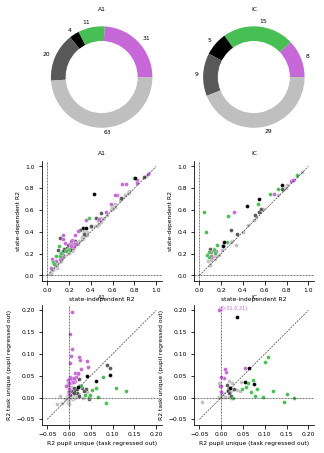

In [124]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as sci
import statsmodels.formula.api as smf
import matplotlib.collections as clt
import re
import pylab as pl

import nems_lbhb.pupil_behavior_scripts.common as common
import nems_lbhb.pupil_behavior_scripts.helpers as helper
from nems_lbhb.analysis.statistics import get_bootstrapped_sample, get_direct_prob
from nems import get_setting

# set path to dump file
dump_path = get_setting('NEMS_RESULTS_DIR')

save_path = os.path.join(os.path.expanduser('~'),'docs/current/pupil_behavior/eps')
save_fig = False

# SPECIFY models
AFL = True
if AFL:
    dump_results = 'd_pup_afl_sdexp.csv'
    #dump_results = 'd_pup_afl_sdexp_ap1.csv'
    model_string = 'st.pup.afl'
    p0_model = 'st.pup0.afl'
    b0_model = 'st.pup.afl0'
    shuf_model = 'st.pup0.afl0'
else:
    dump_results = 'd_pup_fil_sdexp.csv'
    model_string = 'st.pup.fil'
    p0_model = 'st.pup0.fil'
    b0_model = 'st.pup.fil0'
    shuf_model = 'st.pup0.fil0'

# set params for BF characterization and sig. sensory response threshold
octave_cutoff = 0.5
r0_threshold = 0
group_files = True

# import / preprocess model results
A1 = helper.preprocess_sdexp_dump(dump_results,
                                  batch=307,
                                  full_model=model_string,
                                  p0=p0_model,
                                  b0=b0_model,
                                  shuf_model=shuf_model,
                                  r0_threshold=r0_threshold,
                                  octave_cutoff=octave_cutoff,
                                  path=dump_path)
A1['area'] = 'A1'
IC = helper.preprocess_sdexp_dump(dump_results,
                                  batch=309,
                                  full_model=model_string,
                                  p0=p0_model,
                                  b0=b0_model,
                                  shuf_model=shuf_model,
                                  r0_threshold=r0_threshold,
                                  octave_cutoff=octave_cutoff,
                                  path=dump_path)
d_IC_area = pd.read_csv('IC_cells_area.csv', index_col=0)
IC = IC.merge(d_IC_area, on=['cellid'])

df = pd.concat([A1, IC])

if group_files & ('beh' not in model_string):
    area = df['area']
    #df = df.groupby(by=['cellid', 'ON_BF']).mean()
    df = df.groupby(by=['cellid']).mean()
    df['area'] = [area.loc[c] if type(area.loc[c]) is str else area.loc[c].iloc[0] for c in df.index.get_level_values('cellid')]
    df['sig_task'] = df['sig_task'].astype(bool)
    df['sig_utask'] = df['sig_utask'].astype(bool)
    df['sig_pupil'] = df['sig_pupil'].astype(bool)
    df['sig_upupil'] = df['sig_upupil'].astype(bool)
    df['sig_state'] = df['sig_state'].astype(bool)
# Create figure

def donut_plot(area, unit_list, colors, savefigure=False):
    white_circle=plt.Circle((0,0), 0.7, color='white')
    plt.axis('equal')
    plt.pie(unit_list, colors=colors, labels=unit_list)
    p=plt.gcf()
    p.gca().add_artist(white_circle)
    plt.title(area)
    if savefigure:
        plt.savefig(area + '_donut.pdf')

print('A1 had {} units for which behavior alone sign modulated activity'.format(len(df.loc[(df.area=='A1') & df['sig_task']])))
print('A1 had {} units for which behavior unique sign modulated activity'.format(len(df.loc[(df.area=='A1') & df['sig_utask']])))
print('A1 had {} units for which behavior either only or unique sign modulated activity'.format(len(df.loc[(df.area=='A1') &
                                                                                                           (df['sig_task'] | df['sig_utask'])])))
print('IC had {} units for which behavior alone sign modulated activity'.format(len(df.loc[(df.area.isin(['ICC', 'ICX'])) & df['sig_task']])))
print('IC had {} units for which behavior unique sign modulated activity'.format(len(df.loc[(df.area.isin(['ICC', 'ICX']))& df['sig_utask']])))

# Fig 3A
A1_n_sig_both = df[(df.area=='A1') & df['sig_utask'] & df['sig_upupil']].shape[0]
A1_n_sig_ubeh = df[(df.area=='A1') & df['sig_utask']].shape[0] - A1_n_sig_both
A1_n_sig_upup = df[(df.area=='A1') & df['sig_upupil']].shape[0] - A1_n_sig_both
A1_n_sig_state = df[(df.area=='A1') & df['sig_state']].shape[0]
A1_n_sig_either = A1_n_sig_state - (A1_n_sig_both + A1_n_sig_ubeh + A1_n_sig_upup)

A1_n_total = df[df.area=='A1'].shape[0]
A1_n_not_sig = A1_n_total - (A1_n_sig_state)

A1_units = [A1_n_sig_ubeh, A1_n_sig_upup, A1_n_sig_both, A1_n_sig_either, A1_n_not_sig]

# IC

IC_n_sig_both = df[df.area.isin(['ICC', 'ICX']) & df['sig_utask'] & df['sig_upupil']].shape[0]
IC_n_sig_ubeh = df[df.area.isin(['ICC', 'ICX']) & df['sig_utask']].shape[0] - IC_n_sig_both
IC_n_sig_upup = df[df.area.isin(['ICC', 'ICX']) & df['sig_upupil']].shape[0] - IC_n_sig_both
IC_n_sig_state = df[df.area.isin(['ICC', 'ICX']) & df['sig_state']].shape[0]
IC_n_sig_either = IC_n_sig_state - (IC_n_sig_both + IC_n_sig_ubeh + IC_n_sig_upup)

IC_n_total = df[df.area.isin(['ICC', 'ICX'])].shape[0]
IC_n_not_sig = IC_n_total - (IC_n_sig_state)

IC_units = [IC_n_sig_ubeh, IC_n_sig_upup, IC_n_sig_both, IC_n_sig_either, IC_n_not_sig]

colors = [common.color_b, common.color_p, common.color_both, common.color_either, common.color_ns]

# Figure 3A
fh, axs = plt.subplots(3, 2, figsize=(5,7.5))

plt.sca(axs[0,0])
donut_plot('A1', A1_units, colors, savefigure=False)

plt.sca(axs[0,1])
donut_plot('IC', IC_units, colors, savefigure=False)

# Figure 3B

# A1 with colored units according to model significance
common.scat_states_crh(df, x_model='r_shuff',
            y_model='r_full',
            area='A1',
            save=False,
            xlim=(0,1),
            ylim=(0,1),
            xlabel='state-independent R2',
            ylabel='state-dependent R2',
            title='A1',
            ax=axs[1,0],
            bootstats=True)

# All IC with colored untis according to model significance
common.scat_states_crh(df, x_model='r_shuff',
            y_model='r_full',
            area='ICC|ICX',
            save=False,
            xlim=(0,1),
            ylim=(0,1),
            xlabel='state-independent R2',
            ylabel='state-dependent R2',
            title='IC',
            ax=axs[1,1],
            bootstats=True)

# Figure 3C
# A1
common.scat_states_crh(df, x_model='r_pupil_unique',
            y_model='r_task_unique',
            area='A1',
            save=False,
            xlabel='R2 pupil unique (task regressed out)',
            ylabel='R2 task unique (pupil regressed out)',
            title='A1',
            xlim=(-0.05,0.2),
            ylim=(-0.05,0.2),
            ax=axs[2,0],
            bootstats=True)

# IC and ICX together
common.scat_states_crh(df, x_model='r_pupil_unique',
            y_model='r_task_unique',
            area='ICC|ICX',
            save=False,
            xlabel='R2 pupil unique (task regressed out)',
            ylabel='R2 task unique (pupil regressed out)',
            title='IC',
            xlim=(-0.05,0.2),
            ylim=(-0.05,0.2),
            ax=axs[2,1],
            bootstats=True)

#plt.tight_layout()

# add statistical test to directly test if r_pupil/task is different between areas
np.random.seed(123)
df['siteid'] = [c[:7] for c in df.index]

da1_pup = {s: df.loc[(df.siteid==s)& df.sig_state, 'r_pupil_unique'].values for s in df[(df.area=='A1')].siteid.unique()}
dic_pup = {s: df.loc[(df.siteid==s) & df.sig_state, 'r_pupil_unique'].values for s in df[df.area.isin(['ICC', 'ICX'])].siteid.unique()}
da1_beh = {s: df.loc[(df.siteid==s)& df.sig_state, 'r_task_unique'].values for s in df[(df.area=='A1')].siteid.unique()}
dic_beh = {s: df.loc[(df.siteid==s) & df.sig_state, 'r_task_unique'].values for s in df[df.area.isin(['ICC', 'ICX'])].siteid.unique()}

# A1: task vs. pupil:
p = get_bootstrapped_sample(da1_pup, nboot=500)
b = get_bootstrapped_sample(da1_beh, nboot=500)
p = 1- get_direct_prob(p, b)[0]
print(f" Median r_pupil_unique A1: {df[df.area.isin(['A1'])]['r_pupil_unique'].median()}\n"\
      f" Median r_task_unique A1: {df[df.area.isin(['A1'])]['r_task_unique'].median()}\n"\
      f" Bootstrapped probability pup<beh: {p}\n")

# IC: task vs. pupil:
p = get_bootstrapped_sample(dic_pup, nboot=500)
b = get_bootstrapped_sample(dic_beh, nboot=500)
p = 1- get_direct_prob(p, b)[0]
print(f" Median r_pupil_unique IC: {df[df.area.isin(['ICC', 'ICX'])]['r_pupil_unique'].median()}\n"\
      f" Median r_task_unique IC: {df[df.area.isin(['ICC', 'ICX'])]['r_task_unique'].median()}\n"\
      f" Bootstrapped probability pup<beh: {p}\n")

# pupil test
a1 = get_bootstrapped_sample(da1_pup, nboot=500)
ic = get_bootstrapped_sample(dic_pup, nboot=500)
p = 1- get_direct_prob(a1, ic)[0]
print(f" Median r_pupil_unique IC: {df[df.area.isin(['ICC', 'ICX'])]['r_pupil_unique'].median()}\n"\
      f" Median r_pupil_unique A1: {df[df.area.isin(['A1'])]['r_pupil_unique'].median()}\n"\
      f" Bootstrapped probability A1 > IC: {p}\n")

# task test
a1 = get_bootstrapped_sample(da1_beh, nboot=500)
ic = get_bootstrapped_sample(dic_beh, nboot=500)
p = 1- get_direct_prob(a1, ic)[0]
print(f" Median r_task_unique IC: {df[df.area.isin(['ICC', 'ICX'])]['r_task_unique'].median()}\n"\
      f" Median r_task_unique A1: {df[df.area.isin(['A1'])]['r_task_unique'].median()}\n"\
      f" Bootstrapped probability A1 > IC: {p}")

if save_fig:
    fh.savefig(os.path.join(save_path, 'fig3_r2_summ.pdf'))



In [126]:
df=A1.copy()
df['cellid']=df.index.to_list()
df['siteid']=df.cellid.str.slice(0,7)
df['animal']=df.cellid.str.slice(0,3)
listA1=df[['cellid','siteid','animal']].drop_duplicates()
listA1=listA1.drop_duplicates()
listA1.groupby('animal').count()


,cellid,siteid
animal,,
BRT,88,88
TAR,28,28
bbl,13,13


In [127]:
#listA1=df[['siteid','animal','state_chan_alt']].drop_duplicates()
#listA1=listA1[(listA1.state_chan_alt=="ACTIVE_1") | (listA1.state_chan_alt=="ACTIVE_2")]
listA1=df[['siteid','animal']].drop_duplicates()
listA1=listA1.drop_duplicates()
listA1.groupby('animal').count()

,siteid
animal,
BRT,6
TAR,1
bbl,1


### FIGURE 4

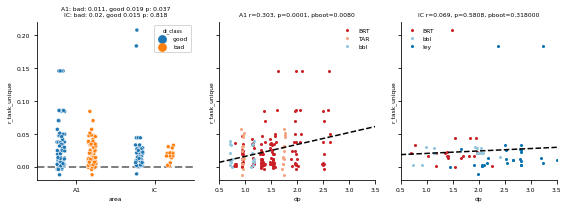

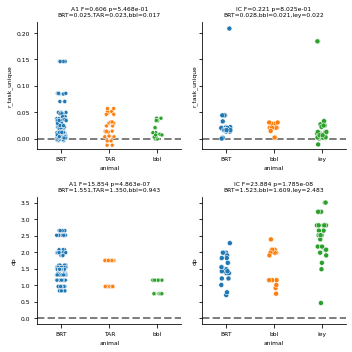

              df    sum_sq   mean_sq          F    PR(>F)
C(animal)    2.0  0.001007  0.000503   0.659443  0.518465
dp           1.0  0.012236  0.012236  16.027088  0.000093
Residual   169.0  0.129024  0.000763        NaN       NaN
             df    sum_sq   mean_sq         F    PR(>F)
C(animal)   2.0  0.000671  0.000336  0.221242  0.802143
dp          1.0  0.001693  0.001693  1.115866  0.294844
Residual   63.0  0.095605  0.001518       NaN       NaN
              df    sum_sq   mean_sq          F        PR(>F)
C(animal)    2.0  0.001007  0.000503   0.839083  4.339093e-01
pnorm_var    1.0  0.040232  0.040232  67.052369  6.353042e-14
dp           1.0  0.000227  0.000227   0.378276  5.393593e-01
Residual   168.0  0.100801  0.000600        NaN           NaN
             df    sum_sq   mean_sq         F    PR(>F)
C(animal)   2.0  0.000671  0.000336  0.217812  0.804890
pnorm_var   1.0  0.000040  0.000040  0.026025  0.872364
dp          1.0  0.001689  0.001689  1.095603  0.299297
Residual  

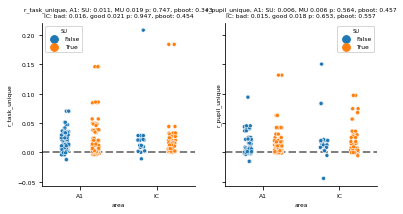

In [130]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from numpy.random import normal

import helpers as helper

from nems_lbhb.analysis.statistics import get_bootstrapped_sample, get_direct_prob
from nems import get_setting
import nems.plots.api as nplt

dump_path = get_setting('NEMS_RESULTS_DIR')

save_path = os.path.join(os.path.expanduser('~'),'docs/current/pupil_behavior/eps')
save_fig = False

r0_threshold = 0.5
octave_cutoff = 0.5
#perf_stat='DI'
perf_stat='dp'

# important options
#yaxis = 'r_pupil_unique'
yaxis = 'r_task_unique'

#yaxis = 'MI_task_unique'
#yaxis = 'MI_task_unique_abs'
#yaxis = 'r_task'

sig_col = 'area'     # sig_utask (sig unique task effect), sig_task (sig task only), sig_state (sig state effect)
easy = [0]             # pure-tone = 0, low SNR = 1, high SNR = 3
medium = [1]
hard = [3]

AFL = True
if AFL:
    dump_results = 'd_pup_afl_sdexp.csv'
    model_string = 'st.pup.afl'
    p0_model = 'st.pup0.afl'
    b0_model = 'st.pup.afl0'
    shuf_model = 'st.pup0.afl0'
else:
    dump_results = 'd_pup_fil_sdexp.csv'
    model_string = 'st.pup.fil'
    p0_model = 'st.pup0.fil'
    b0_model = 'st.pup.fil0'
    shuf_model = 'st.pup0.fil0'

A1 = helper.preprocess_sdexp_dump(dump_results,
                                  batch=307,
                                  full_model=model_string,
                                  p0=p0_model,
                                  b0=b0_model,
                                  shuf_model=shuf_model,
                                  r0_threshold=r0_threshold,
                                  octave_cutoff=octave_cutoff,
                                  path=dump_path)
A1 = A1[A1.sig_psth]

IC = helper.preprocess_sdexp_dump(dump_results,
                                  batch=309,
                                  full_model=model_string,
                                  p0=p0_model,
                                  b0=b0_model,
                                  shuf_model=shuf_model,
                                  r0_threshold=r0_threshold,
                                  octave_cutoff=octave_cutoff,
                                  path=dump_path)
IC = IC[IC.sig_psth]

# convert difficulty to True (for hard) and False (for easy)
#A1['difficulty'] = [True if x in hard else False for x in A1.difficulty]
#IC['difficulty'] = [True if x in hard else False for x in IC.difficulty]

A1['animal']=A1.index.copy().str[:3]
IC['animal']=IC.index.copy().str[:3]
A1['MI_task_unique_abs'] = np.abs(A1['MI_task_unique'])
IC['MI_task_unique_abs'] = np.abs(IC['MI_task_unique'])
A1['area']='A1'
IC['area']='IC'
# compress DI slightly to avoid explosions
#A1['dp']=-np.log(100/A1.DI-1)
A1['dp']=-np.log(100/(A1.DI*0.92+6)-1)
A1.loc[A1.dp>3.5,'dp']=3.5
#IC['dp']=-np.log(100/IC.DI-1)
IC['dp']=-np.log(100/(IC.DI*0.92+6)-1)
IC.loc[IC.dp>3.5,'dp']=3.5

d = pd.concat((A1,IC))

split=82
d['di_class']='good'
d.loc[d.DI<split, 'di_class']='bad'

jitter_mag = 0.015
ms = 4

# Good vs. bad behavior
f1, ax = plt.subplots(1, 3, figsize=(8, 3), sharey='row')

sns.stripplot(x=sig_col, y=yaxis, data=d, hue='di_class', dodge=True, edgecolor='white', linewidth=0.5,
                        marker='o', size=ms, ax=ax[0])
ax[0].axhline(0, linestyle='--', lw=2, color='grey')

# medians
bad_med_a1 = round(d[(d.di_class=='bad') & (d.area=='A1')][yaxis].median(), 3)
good_med_a1 = round(d[(d.di_class=='good')  & (d.area=='A1')][yaxis].median(), 3)
bad_med_ic = round(d[(d.di_class=='bad') & (d.area=='IC')][yaxis].median(), 3)
good_med_ic = round(d[(d.di_class=='good')  & (d.area=='IC')][yaxis].median(), 3)

# pvals
bad_v_good_a1 = round(ss.ranksums(d[(d.di_class=='bad') & (d.area=='A1')][yaxis],
                                  d[(d.di_class=='good') & (d.area=='A1')][yaxis]).pvalue, 3)
bad_v_good_ic = round(ss.ranksums(d[(d.di_class=='bad') & (d.area=='IC')][yaxis],
                                  d[(d.di_class=='good') & (d.area=='IC')][yaxis]).pvalue, 3)

ax[0].set_title('A1: bad: {0}, good {1} p: {2:.3f}\nIC: bad: {3}, good {4} p: {5:.3f}'.format(
    bad_med_a1, good_med_a1, bad_v_good_a1,
    bad_med_ic, good_med_ic, bad_v_good_ic))
ax[0].set_ylim([-0.02, 0.22])
nplt.ax_remove_box(ax[0])

animal_colors = {'TAR': [244/255, 165/255, 130/255],
                 'bbl': [147/255, 197/255, 222/255],
                 'ley': [5/255, 113/255, 176/255],
                 'BRT': [202/255, 32/255, 39/255]}

for a in A1.animal.unique():
    _k = (d.area=='A1') & (d.animal==a)
    ax[1].plot(d.loc[_k, perf_stat]+normal(0,jitter_mag,np.sum(_k)),
               d.loc[_k, yaxis], '.', markersize=ms, color=animal_colors[a])
r, p = ss.pearsonr(d[(d.area=='A1')][perf_stat], d[(d.area=='A1')][yaxis])
beta = np.polyfit(d[(d.area=='A1')][perf_stat], d[(d.area=='A1')][yaxis],1)

# add bootstrapped test of correlation
np.random.seed(123)
# unique site / active combos
d['siteid'] = [c[:7]+d['state_chan_alt'].iloc[i] for i, c in enumerate(d.index)]
x = {s: d.loc[(d.siteid==s) & (d.area=='A1'), perf_stat].values for s in d[(d.area=='A1')].siteid.unique()}
y = {s: d.loc[(d.siteid==s) & (d.area=='A1'), yaxis].values for s in d[(d.area=='A1')].siteid.unique()}
cc = get_bootstrapped_sample(x, y, metric='corrcoef', nboot=500)
pboot = get_direct_prob(cc, np.zeros(cc.shape[0]))[0]
ax[1].set_title(f'A1 r={r:.3f}, p={p:.4f}, pboot={pboot:.4f}')
ax[1].set_xlabel(perf_stat)
ax[1].set_ylabel(yaxis)
if perf_stat=='DI':
    x0=np.array([58,102])
else:
    x0=np.array([0.5,3.5])
ax[1].plot(x0,x0*beta[0]+beta[1],'k--')
ax[1].set_xlim(x0)
ax[1].legend(A1.animal.unique(), frameon=False)
nplt.ax_remove_box(ax[1])

for a in IC.animal.unique():
    _k = (d.area=='IC') & (d.animal==a)
    ax[2].plot(d.loc[_k, perf_stat]+normal(0,jitter_mag,np.sum(_k)),
               d.loc[_k, yaxis], '.', markersize=ms, color=animal_colors[a])
r, p = ss.pearsonr(d[(d.area=='IC')][perf_stat], d[(d.area=='IC')][yaxis])
beta = np.polyfit(d[(d.area=='IC')][perf_stat], d[(d.area=='IC')][yaxis],1)
# bootstrapped test
x = {s: d.loc[(d.siteid==s) & (d.area=='IC'), perf_stat].values for s in d[(d.area=='IC')].siteid.unique()}
y = {s: d.loc[(d.siteid==s) & (d.area=='IC'), yaxis].values for s in d[(d.area=='IC')].siteid.unique()}
cc = get_bootstrapped_sample(x, y, metric='corrcoef', nboot=500)
pboot = get_direct_prob(cc, np.zeros(cc.shape[0]))[0]

ax[2].set_title(f'IC r={r:.3f}, p={p:.4f}, pboot={pboot:4f}')
ax[2].set_xlabel(perf_stat)
ax[2].set_ylabel(yaxis)
if perf_stat=='DI':
    x0=np.array([58,102])
else:
    x0=np.array([0.5,3.5])
ax[2].plot(x0,x0*beta[0]+beta[1],'k--')
ax[2].set_xlim(x0)
ax[2].legend(IC.animal.unique(), frameon=False)
nplt.ax_remove_box(ax[2])

f1.tight_layout()



f2,ax = plt.subplots(2,2, figsize=(5, 5), sharey='row')
sns.stripplot(x='animal', y=yaxis, data=A1, dodge=True, edgecolor='white', linewidth=0.5,
                        marker='o', size=ms, ax=ax[0,0])
ax[0,0].axhline(0, linestyle='--', lw=2, color='grey')
sets_a1 = [A1.loc[A1['animal']==a, yaxis] for a in A1.animal.unique()]
means_a1 = [f'{a}={A1.loc[A1["animal"]==a, yaxis].mean():.3f}' for a in A1.animal.unique()]
F,p = ss.f_oneway(*sets_a1)
ax[0,0].set_title(f'A1 F={F:.3f} p={p:.3e}\n{",".join(means_a1)}')
nplt.ax_remove_box(ax[0,0])

sns.stripplot(x='animal', y=yaxis, data=IC, dodge=True, edgecolor='white', linewidth=0.5,
                        marker='o', size=5, ax=ax[0,1])
ax[0,1].axhline(0, linestyle='--', lw=2, color='grey')
sets_ic = [IC.loc[IC['animal']==a, yaxis] for a in IC.animal.unique()]
means_ic = [f'{a}={IC.loc[IC["animal"]==a, yaxis].mean():.3f}' for a in IC.animal.unique()]
F,p = ss.f_oneway(*sets_ic)
ax[0,1].set_title(f'IC F={F:.3f} p={p:.3e}\n{",".join(means_ic)}')
ax[0,1].set_ylim([-0.02, 0.22])
nplt.ax_remove_box(ax[0,1])

sns.stripplot(x='animal', y=perf_stat, data=A1, dodge=True, edgecolor='white', linewidth=0.5,
                        marker='o', size=ms, ax=ax[1,0])
if perf_stat=='DI':
    ax[1,0].axhline(50, linestyle='--', lw=2, color='grey')
else:
    ax[1,0].axhline(0, linestyle='--', lw=2, color='grey')
sets_a1 = [A1.loc[A1['animal']==a, perf_stat] for a in A1.animal.unique()]
means_a1 = [f'{a}={A1.loc[A1["animal"]==a, perf_stat].mean():.3f}' for a in A1.animal.unique()]
F,p = ss.f_oneway(*sets_a1)
ax[1,0].set_title(f'A1 F={F:.3f} p={p:.3e}\n{",".join(means_a1)}')
nplt.ax_remove_box(ax[1,0])

sns.stripplot(x='animal', y=perf_stat, data=IC, dodge=True, edgecolor='white', linewidth=0.5,
                        marker='o', size=5, ax=ax[1,1])
if perf_stat=='DI':
    ax[1,1].axhline(50, linestyle='--', lw=2, color='grey')
else:
    ax[1,1].axhline(0, linestyle='--', lw=2, color='grey')
sets_ic = [IC.loc[IC['animal']==a, perf_stat] for a in IC.animal.unique()]
means_ic = [f'{a}={IC.loc[IC["animal"]==a, perf_stat].mean():.3f}' for a in IC.animal.unique()]
F,p = ss.f_oneway(*sets_ic)
ax[1,1].set_title(f'IC F={F:.3f} p={p:.3e}\n{",".join(means_ic)}')

nplt.ax_remove_box(ax[1,1])

f2.tight_layout()

plt.show()
from statsmodels.graphics.api import interaction_plot, abline_plot

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula = f'{yaxis} ~ C(animal) + ' + perf_stat
lm = ols(formula, A1).fit()
table1 = anova_lm(lm)
print(table1)
lm = ols(formula, IC).fit()
table1 = anova_lm(lm)
print(table1)

# same stats, include pupil variance as an explanatory variable
path = os.path.dirname(helper.__file__)
pup_var = path + '/pupilVariance.csv'
pvar = pd.read_csv(pup_var, index_col=0)
A1 = A1.merge(pvar, on='cellid')
IC = IC.merge(pvar, on='cellid')
formula = f'{yaxis} ~ C(animal) + pnorm_var + ' + perf_stat
lm = ols(formula, A1).fit()
table1 = anova_lm(lm)
print(table1)
lm = ols(formula, IC).fit()
table1 = anova_lm(lm)
print(table1)

# SU vs. MU
d['siteid'] = [c[:7] for c in d.index]
f3, ax = plt.subplots(1, 2, figsize=(6, 3), sharey='row')

for _i, _yax in enumerate(['r_task_unique', 'r_pupil_unique']):
    sns.stripplot(x=sig_col, y=_yax, data=d, hue='SU', dodge=True, edgecolor='white', linewidth=0.5,
                            marker='o', size=ms, ax=ax[_i])
    ax[_i].axhline(0, linestyle='--', lw=2, color='grey')

    # medians
    bad_med_a1 = round(d[(d.SU) & (d.area=='A1')][_yax].median(), 3)
    good_med_a1 = round(d[(~d.SU)  & (d.area=='A1')][_yax].median(), 3)
    bad_med_ic = round(d[(d.SU) & (d.area=='IC')][_yax].median(), 3)
    good_med_ic = round(d[(~d.SU)  & (d.area=='IC')][_yax].median(), 3)

    # pvals
    bad_v_good_a1 = round(ss.ranksums(d[d.SU & (d.area=='A1')][_yax],
                                      d[~d.SU & (d.area=='A1')][_yax]).pvalue, 3)
    bad_v_good_ic = round(ss.ranksums(d[d.SU & (d.area=='IC')][_yax],
                                      d[~d.SU & (d.area=='IC')][_yax]).pvalue, 3)

    # bootstrap pvalues
    a1_su = {s: d[(d.siteid==s) & d.SU & d.area.isin(['A1'])][_yax].values for s in d[d.area.isin(['A1']) & d.SU].siteid.unique()}
    a1_mu = {s: d[(d.siteid==s) & ~d.SU & d.area.isin(['A1'])][_yax].values for s in d[d.area.isin(['A1']) & ~d.SU].siteid.unique()}
    a1_su = get_bootstrapped_sample(a1_su, nboot=500)
    a1_mu = get_bootstrapped_sample(a1_mu, nboot=500)
    bvg_a1_boot = get_direct_prob(a1_su, a1_mu)[0]

    ic_su = {s: d[(d.siteid==s) & d.SU & d.area.isin(['IC'])][_yax].values for s in d[d.area.isin(['IC']) & d.SU].siteid.unique()}
    ic_mu = {s: d[(d.siteid==s) & ~d.SU & d.area.isin(['IC'])][_yax].values for s in d[d.area.isin(['IC']) & ~d.SU].siteid.unique()}
    ic_su = get_bootstrapped_sample(ic_su, nboot=500)
    ic_mu = get_bootstrapped_sample(ic_mu, nboot=500)
    bvg_ic_boot = get_direct_prob(ic_su, ic_mu)[0]

    ax[_i].set_title('{6}, A1: SU: {0}, MU {1} p: {2:.3f}, pboot: {7:.3f}\nIC: bad: {3}, good {4} p: {5:.3f}, pboot: {8:.3f}'.format(
        bad_med_a1, good_med_a1, bad_v_good_a1,
        bad_med_ic, good_med_ic, bad_v_good_ic, _yax, bvg_a1_boot, bvg_ic_boot))
    nplt.ax_remove_box(ax[_i])

if save_fig:
    f1.savefig(os.path.join(save_path, f'figSn_performance_sum_{yaxis}.pdf'))
    f2.savefig(os.path.join(save_path, f'figSn_animal_sum_{yaxis}.pdf'))
    f3.savefig(os.path.join(save_path, f'figSn_su_mu_comp_{yaxis}.pdf'))



In [145]:
area='IC'
d['siteid'] = [c[:7]+d['state_chan_alt'].iloc[i] for i, c in enumerate(d.index)]
x = {s: d.loc[(d.siteid==s), perf_stat].values for s in d[(d.area==area)].siteid.unique()}
y = {s: d.loc[(d.siteid==s), yaxis].values for s in d[(d.area==area)].siteid.unique()}
cc = get_bootstrapped_sample(x, y, metric='corrcoef', nboot=1000)
pboot = get_direct_prob(cc, np.zeros(cc.shape[0]))[0]
perf_stat, yaxis, pboot, np.sum([1 for k,v in x.items()])

('dp', 'r_task_unique', 0.354, 48)

### FIGURE 5

Area=A1 X=MI_task=0.044, Y=MI_task_unique=0.011
  Wilcoxon sign test: stat=1612.0, p=2.839e-10 R: 0.844, p=4.655e-37
   Hierarcichal bootstrap probability: 0.999
Area=ICC X=MI_task=-0.006, Y=MI_task_unique=0.013
  Wilcoxon sign test: stat=132.0, p=6.071e-01 R: 0.889, p=6.643e-09
   Hierarcichal bootstrap probability: 0.31099999999999994
Area=ICX X=MI_task=-0.010, Y=MI_task_unique=-0.034
  Wilcoxon sign test: stat=612.0, p=1.660e-02 R: 0.641, p=2.592e-08
   Hierarcichal bootstrap probability: 0.974
A1 mean MI task only, unique: 0.103, 0.064
  signed delta task unique: stat=1672.000, p=6.7835e-10
  Ratio: 0.330
IC mean MI task only, unique: 0.038, 0.037
  signed delta task unique: stat=1417.000, p=7.2064e-02
  Ratio: 0.333

 A1 task only vs. task unique bootstrapped prob: 0.0


 IC task only vs. task unique bootstrapped prob: 0.083

 ICC signed delta task unique: stat=57.000, p=7.8806e-03, pboot=0.0020
  Ratio: 0.430
 ICX signed delta task unique: stat=865.000, p=5.6312e-01, pboot=0.2230

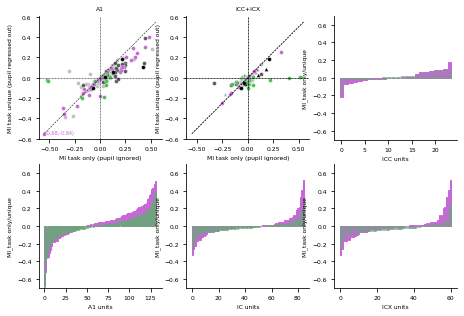

In [122]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as sci
import statsmodels.formula.api as smf
import matplotlib.collections as clt
import re
import pylab as pl

from nems_lbhb.pupil_behavior_scripts.mod_per_state import get_model_results_per_state_model
from nems_lbhb.pupil_behavior_scripts.mod_per_state import aud_vs_state
from nems_lbhb.pupil_behavior_scripts.mod_per_state import hlf_analysis
from nems_lbhb.pupil_behavior_scripts.mod_per_state import beh_only_plot
from nems_lbhb.stateplots import model_per_time_wrapper, beta_comp
from nems import get_setting
import nems.plots.api as nplt
import nems_lbhb.pupil_behavior_scripts.common as common
import nems_lbhb.pupil_behavior_scripts.helpers as helper
from nems_lbhb.analysis.statistics import get_bootstrapped_sample, get_direct_prob

# set path to dump file
dump_path = get_setting('NEMS_RESULTS_DIR')
helper_path = os.path.dirname(helper.__file__)

save_path = os.path.join(os.path.expanduser('~'),'docs/current/pupil_behavior/eps')
save_fig = False

# SPECIFY models
USE_AFL=True
if USE_AFL:
    dump_results = 'd_pup_afl_sdexp.csv'
    model_string = 'st.pup.afl'
    p0_model = 'st.pup0.afl'
    b0_model = 'st.pup.afl0'
    shuf_model = 'st.pup0.afl0'
else:
    dump_results = 'd_pup_beh_sdexp.csv'
    model_string = 'st.pup.beh'
    p0_model = 'st.pup0.beh'
    b0_model = 'st.pup.beh0'
    shuf_model = 'st.pup0.beh0'


# set params for BF characterization and sig. sensory response threshold
octave_cutoff = 0.5
r0_threshold = 0
group_files = True

# import / preprocess model results
A1 = helper.preprocess_sdexp_dump(dump_results,
                                  batch=307,
                                  full_model=model_string,
                                  p0=p0_model,
                                  b0=b0_model,
                                  shuf_model=shuf_model,
                                  r0_threshold=r0_threshold,
                                  octave_cutoff=octave_cutoff,
                                  path=dump_path)
A1['area'] = 'A1'
IC = helper.preprocess_sdexp_dump(dump_results,
                                  batch=309,
                                  full_model=model_string,
                                  p0=p0_model,
                                  b0=b0_model,
                                  shuf_model=shuf_model,
                                  r0_threshold=r0_threshold,
                                  octave_cutoff=octave_cutoff,
                                  path=dump_path)
d_IC_area = pd.read_csv('IC_cells_area.csv', index_col=0)
IC = IC.merge(d_IC_area, on=['cellid'])

df = pd.concat([A1, IC])

if group_files & ('beh' not in model_string):
    area = df['area']
    df = df.groupby(by=['cellid', 'ON_BF']).mean()
    df['area'] = [area.loc[c] if type(area.loc[c]) is str else area.loc[c].iloc[0] for c in df.index.get_level_values('cellid')]
    df=df.reset_index()
    df.index = df.cellid
    
fh, axs = plt.subplots(2, 3, figsize=(7.5,5))

# Figure 4A
# A1
rr=(-0.55, 0.55)
common.scat_states_crh(df, x_model='MI_task',
            y_model='MI_task_unique',
            area='A1',
            save=False,
            xlabel='MI task only (pupil ignored)',
            ylabel='MI task unique (pupil regressed out)',
            title='A1',
            xlim=rr,
            ylim=rr,
            ax=axs[0,0], 
            bootstats=True)

# ICC
common.scat_states_crh(df, x_model='MI_task',
            y_model='MI_task_unique',
            area='ICC',
            save=False,
            xlabel='MI task only (pupil ignored)',
            ylabel='MI task unique (pupil regressed out)',
            title='ICC',
            xlim=rr,
            ylim=rr,
            marker='^',
            ax=axs[0,1],
            bootstats=True)

# ICX
common.scat_states_crh(df, x_model='MI_task',
            y_model='MI_task_unique',
            area='ICX',
            save=False,
            xlabel='MI task only (pupil ignored)',
            ylabel='MI task unique (pupil regressed out)',
            title='ICC+ICX',
            xlim=rr,
            ylim=rr,
            marker='o',
            ax=axs[0,1], 
            bootstats=True)

# Figure 4B

# sort based on MI
df_MI_unique_sorted = df.sort_values('MI_task_unique')
df_MI_only_sorted = df.sort_values('MI_task')

x_axis_A1 = np.arange(0, (df.area=='A1').sum())
x_axis_ICC = np.arange(0, (df.area=='ICC').sum())
x_axis_ICX = np.arange(0, (df.area=='ICX').sum())
x_axis_IC = np.arange(0, df.area.isin(['ICC', 'ICX']).sum())

axs[1, 0].bar(x_axis_A1, df_MI_only_sorted.loc[df_MI_only_sorted.area=='A1', 'MI_task'], color = common.color_b, edgecolor = common.color_b)
axs[1, 0].bar(x_axis_A1, df_MI_unique_sorted.loc[df_MI_unique_sorted.area=='A1', 'MI_task_unique'], color = common.color_b,
        edgecolor = common.color_p, linewidth=0.5)
axs[1, 0].set_ylim((-0.7,0.7))
axs[1, 0].set_xlabel('A1 units')
axs[1, 0].set_ylabel('MI_task only/unique')
#plt.savefig('MI_task_only_A1.pdf')
nplt.ax_remove_box(axs[1,0])


axs[1, 1].bar(x_axis_IC, df_MI_only_sorted.loc[df_MI_only_sorted.area.isin(['ICC', 'ICX']), 'MI_task'],
                                color = common.color_b, edgecolor = common.color_b)
axs[1, 1].bar(x_axis_IC, df_MI_unique_sorted.loc[df_MI_unique_sorted.area.isin(['ICC', 'ICX']), 'MI_task_unique'],
                                color=common.color_b, edgecolor=common.color_p, linewidth=0.5)
axs[1, 1].set_ylim((-0.7,0.7))
axs[1, 1].set_xlabel('IC units')
axs[1, 1].set_ylabel('MI_task only/unique')
#plt.savefig('MI_task_unique_IC.pdf')
nplt.ax_remove_box(axs[1,1])

axs[0, 2].bar(x_axis_ICC, df_MI_only_sorted.loc[df_MI_only_sorted.area.isin(['ICC']), 'MI_task'],
                                color = common.color_b, edgecolor = common.color_b)
axs[0, 2].bar(x_axis_ICC, df_MI_unique_sorted.loc[df_MI_unique_sorted.area.isin(['ICC']), 'MI_task_unique'],
                                color=common.color_b, edgecolor=common.color_p, linewidth=0.5)
axs[0, 2].set_ylim((-0.7,0.7))
axs[0, 2].set_xlabel('ICC units')
axs[0, 2].set_ylabel('MI_task only/unique')
nplt.ax_remove_box(axs[1,1])

axs[1, 2].bar(x_axis_ICX, df_MI_only_sorted.loc[df_MI_only_sorted.area.isin(['ICX']), 'MI_task'],
                                color = common.color_b, edgecolor = common.color_b)
axs[1, 2].bar(x_axis_ICX, df_MI_unique_sorted.loc[df_MI_unique_sorted.area.isin(['ICX']), 'MI_task_unique'],
                                color=common.color_b, edgecolor=common.color_p, linewidth=0.5)
axs[1, 2].set_ylim((-0.7,0.7))
axs[1, 2].set_xlabel('ICX units')
axs[1, 2].set_ylabel('MI_task only/unique')
nplt.ax_remove_box(axs[1,1])



# ===================================== Stats stuff ==============================================
# To quantify differences in modulation without the confounding element of sign let's do
# (MItask only - MItask unique) * sign((MItask only+MItask unique)/2)
# and calculate how much that differs from zero

# A1
sign_A1 = np.sign((df.loc[df.area=='A1', 'MI_task_unique'] +
                           df.loc[df.area=='A1','MI_task'])/2)

signed_diff_A1 = (df.loc[df.area=='A1', 'MI_task']
                  -df.loc[df.area=='A1', 'MI_task_unique']) * sign_A1

signed_only_A1 = df.loc[df.area=='A1', 'MI_task'] * sign_A1

signed_unique_A1 = df.loc[df.area=='A1', 'MI_task_unique'] * sign_A1
unique_A1 = df.loc[(df.area=='A1') & df['sig_state'], 'MI_task_unique']

diff_A1 = (df.loc[df.area=='A1', 'MI_task']
                  -df.loc[df.area=='A1', 'MI_task_unique'])

diff_A1_sig_state = (df.loc[(df.area=='A1') & df['sig_state'], 'MI_task']
                  -df.loc[(df.area=='A1') & df['sig_state'], 'MI_task_unique'])

# A1 onBF
signed_diff_A1_onBF = (df.loc[(df.area=='A1') & df['ON_BF'],
                  'MI_task']-df.loc[(df.area=='A1') & df['ON_BF'],
                                         'MI_task_unique']) * np.sign((df.loc[(df.area=='A1') & df['ON_BF'],
                                                                          'MI_task_unique']+df.loc[(df.area=='A1') & df['ON_BF'],
                                                                                                 'MI_task'])/2)

# A1 offBF
signed_diff_A1_offBF = (df.loc[(df.area=='A1') & df['OFF_BF'],
                  'MI_task']-df.loc[(df.area=='A1') & df['OFF_BF'],
                                         'MI_task_unique']) * np.sign((df.loc[(df.area=='A1') & df['OFF_BF'],
                                                                          'MI_task_unique']+df.loc[(df.area=='A1') & df['OFF_BF'],
                                                                                                 'MI_task'])/2)

# A1 SU
signed_diff_A1_SU = (df.loc[(df.area=='A1') & df['SU'],
                  'MI_task']-df.loc[(df.area=='A1') & df['SU'],
                                         'MI_task_unique']) * np.sign((df.loc[(df.area=='A1') & df['SU'],
                                                                          'MI_task_unique']+df.loc[(df.area=='A1') & df['SU'],
                                                                                                 'MI_task'])/2)

# A1 MU
signed_diff_A1_MU = (df.loc[(df.area=='A1') & ~df['SU'],
                  'MI_task']-df.loc[(df.area=='A1') & ~df['SU'],
                                         'MI_task_unique']) * np.sign((df.loc[(df.area=='A1') & ~df['SU'],
                                                                          'MI_task_unique']+df.loc[(df.area=='A1') & ~df['SU'],
                                                                                                 'MI_task'])/2)

######################
# IC all

sign_IC = np.sign((df.loc[df.area.isin(['ICC', 'ICX']), 'MI_task_unique']+
                           df.loc[df.area.isin(['ICC', 'ICX']),'MI_task'])/2)
sign_ICC = np.sign((df.loc[df.area.isin(['ICC']), 'MI_task_unique']+
                           df.loc[df.area.isin(['ICC']),'MI_task'])/2)
sign_ICX = np.sign((df.loc[df.area.isin(['ICX']), 'MI_task_unique']+
                           df.loc[df.area.isin(['ICX']),'MI_task'])/2)

signed_diff_IC = (df.loc[df.area.isin(['ICC', 'ICX']), 'MI_task']
                  -df.loc[df.area.isin(['ICC', 'ICX']), 'MI_task_unique']) * sign_IC


signed_only_IC = df.loc[df.area.isin(['ICC', 'ICX']), 'MI_task'] * sign_IC
signed_unique_IC = df.loc[df.area.isin(['ICC', 'ICX']), 'MI_task_unique'] * sign_IC
signed_only_ICC = df.loc[df.area.isin(['ICC']), 'MI_task'] * sign_ICC
signed_unique_ICC = df.loc[df.area.isin(['ICC']), 'MI_task_unique'] * sign_ICC
signed_only_ICX = df.loc[df.area.isin(['ICX']), 'MI_task'] * sign_ICX
signed_unique_ICX = df.loc[df.area.isin(['ICX']), 'MI_task_unique'] * sign_ICX
unique_IC = df.loc[df.area.isin(['ICC', 'ICX']) & df['sig_state'], 'MI_task_unique']
unique_ICC = df.loc[df.area.isin(['ICC']) & df['sig_state'], 'MI_task_unique']
unique_ICX = df.loc[df.area.isin(['ICX']) & df['sig_state'], 'MI_task_unique']

diff_IC = (df.loc[df.area.isin(['ICC', 'ICX']), 'MI_task']
                  -df.loc[df.area.isin(['ICC', 'ICX']), 'MI_task_unique'])

diff_IC_sig_state = (df.loc[df.area.isin(['ICC', 'ICX']) & df['sig_state'], 'MI_task']
                  -df.loc[df.area.isin(['ICC', 'ICX']) & df['sig_state'], 'MI_task_unique'])



# IC onBF
signed_diff_IC_onBF = (df.loc[df.area.isin(['ICC', 'ICX']) & df['ON_BF'],
                  'MI_task']-df.loc[df.area.isin(['ICC', 'ICX']) & df['ON_BF'],
                                         'MI_task_unique']) * np.sign((df.loc[df.area.isin(['ICC', 'ICX']) & df['ON_BF'],
                                                                          'MI_task_unique']+df.loc[df.area.isin(['ICC', 'ICX']) & df['ON_BF'],
                                                                                                 'MI_task'])/2)

# IC onBF
signed_diff_IC_offBF = (df.loc[df.area.isin(['ICC', 'ICX']) & df['OFF_BF'],
                  'MI_task']-df.loc[df.area.isin(['ICC', 'ICX']) & df['OFF_BF'],
                                         'MI_task_unique']) * np.sign((df.loc[df.area.isin(['ICC', 'ICX']) & df['OFF_BF'],
                                                                          'MI_task_unique']+df.loc[df.area.isin(['ICC', 'ICX']) & df['OFF_BF'],
                                                                                                 'MI_task'])/2)


# ICC
signed_diff_ICC = (df.loc[(df.area=='ICC'),
                  'MI_task']-df.loc[(df.area=='ICC'),
                                         'MI_task_unique']) * np.sign((df.loc[(df.area=='ICC'),
                                                                          'MI_task_unique']+df.loc[(df.area=='ICC'),
                                                                                                 'MI_task'])/2)

# ICX
signed_diff_ICX = (df.loc[(df.area=='ICX'),
                  'MI_task']-df.loc[(df.area=='ICX'),
                                         'MI_task_unique']) * np.sign((df.loc[(df.area=='ICX'),
                                                                          'MI_task_unique']+df.loc[(df.area=='ICX'),
                                                                                                 'MI_task'])/2)


# IC SU
signed_diff_IC_SU = (df.loc[df.area.isin(['ICC', 'ICX'])  & df['SU'],
                  'MI_task']-df.loc[df.area.isin(['ICC', 'ICX'])  & df['SU'],
                                         'MI_task_unique']) * np.sign((df.loc[df.area.isin(['ICC', 'ICX'])  & df['SU'],
                                                                          'MI_task_unique']+df.loc[df.area.isin(['ICC', 'ICX'])  & df['SU'],
                                                                                                 'MI_task'])/2)

# IC MU
signed_diff_IC_MU = (df.loc[df.area.isin(['ICC', 'ICX'])  & ~df['SU'], 'MI_task']
                     -df.loc[df.area.isin(['ICC', 'ICX'])  & ~df['SU'],
                             'MI_task_unique']) * np.sign((df.loc[df.area.isin(['ICC', 'ICX'])  & ~df['SU'],
                             'MI_task_unique']+df.loc[df.area.isin(['ICC', 'ICX'])  & ~df['SU'], 'MI_task'])/2)


ratio_A1 = 1 - (signed_unique_A1.mean() / signed_only_A1.mean())
ratio_IC = 1 - (signed_unique_IC.mean() / signed_only_IC.mean())
ratio_ICC = 1 - (signed_unique_ICC.mean() / signed_only_ICC.mean())
ratio_ICX = 1 - (signed_unique_ICX.mean() / signed_only_ICX.mean())

stat, p = sci.wilcoxon(signed_diff_A1)
print(f'A1 mean MI task only, unique: {signed_only_A1.median():.3f}, {signed_unique_A1.median():.3f}')
print(f'  signed delta task unique: stat={stat:.3f}, p={p:.4e}')
print(f'  Ratio: {ratio_A1:.3f}')
stat, p = sci.wilcoxon(signed_diff_IC)
print(f'IC mean MI task only, unique: {signed_only_IC.median():.3f}, {signed_unique_IC.median():.3f}')
print(f'  signed delta task unique: stat={stat:.3f}, p={p:.4e}')
print(f'  Ratio: {ratio_IC:.3f}')

# run the above two comparisons with bootstrapped test
np.random.seed(123)
signed_diff_A1_wSite = pd.DataFrame(signed_diff_A1, columns=['signed_diff'])
signed_diff_A1_wSite['siteid'] = [c[:7] for c in signed_diff_A1_wSite.index]
signed_diff_IC_wSite = pd.DataFrame(signed_diff_IC, columns=['signed_diff'])
signed_diff_IC_wSite['siteid'] = [c[:7] for c in signed_diff_IC_wSite.index]

a1 = {s: signed_diff_A1_wSite.loc[(signed_diff_A1_wSite.siteid==s), 'signed_diff'].values for s in signed_diff_A1_wSite.siteid.unique()}
a1 = get_bootstrapped_sample(a1, nboot=1000)
p = get_direct_prob(a1, np.zeros(a1.shape[0]))[0]
print(f"\n A1 task only vs. task unique bootstrapped prob: {p}\n")
ic = {s: signed_diff_IC_wSite.loc[(signed_diff_IC_wSite.siteid==s), 'signed_diff'].values for s in signed_diff_IC_wSite.siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=1000)
p = get_direct_prob(ic, np.zeros(ic.shape[0]))[0]
print(f"\n IC task only vs. task unique bootstrapped prob: {p}\n")

# ICC vs. ICX comparison with bootstrap
signed_diff_ICC_wSite = pd.DataFrame(signed_diff_ICC, columns=['signed_diff'])
signed_diff_ICC_wSite['siteid'] = [c[:7] for c in signed_diff_ICC_wSite.index]
signed_diff_ICX_wSite = pd.DataFrame(signed_diff_ICX, columns=['signed_diff'])
signed_diff_ICX_wSite['siteid'] = [c[:7] for c in signed_diff_ICX_wSite.index]

# split up ICC / ICX
stat, p = sci.wilcoxon(signed_diff_ICC)
icc = {s: signed_diff_ICC_wSite.loc[(signed_diff_ICC_wSite.siteid==s), 'signed_diff'].values for s in signed_diff_ICC_wSite.siteid.unique()}
icc = get_bootstrapped_sample(icc, nboot=1000)
pboot = get_direct_prob(icc, np.zeros(icc.shape[0]))[0]
print(f' ICC signed delta task unique: stat={stat:.3f}, p={p:.4e}, pboot={pboot:.4f}')
print(f'  Ratio: {ratio_ICC:.3f}')

stat, p = sci.wilcoxon(signed_diff_ICX)
icx = {s: signed_diff_ICX_wSite.loc[(signed_diff_ICX_wSite.siteid==s), 'signed_diff'].values for s in signed_diff_ICX_wSite.siteid.unique()}
icx = get_bootstrapped_sample(icx, nboot=1000)
pboot = get_direct_prob(icx, np.zeros(icx.shape[0]))[0]
print(f' ICX signed delta task unique: stat={stat:.3f}, p={p:.4e}, pboot={pboot:.4f}')
print(f'  Ratio: {ratio_ICX:.3f}')

stat, p = sci.ranksums(signed_unique_A1 / signed_only_A1,
                       signed_unique_IC / signed_only_IC)
print(f'A1 vs. IC rank sum ratio: stat={stat:.3f}, p={p:.4e}')
stat, p = sci.ranksums(signed_unique_ICC / signed_only_ICC,
                       signed_unique_ICX / signed_only_ICX)
print(f'ICC vs. ICX rank sum ratio: stat={stat:.3f}, p={p:.4e}')


icx = {s: signed_diff_ICX_wSite.loc[(signed_diff_ICX_wSite.siteid==s), 'signed_diff'].values for s in signed_diff_ICX_wSite.siteid.unique()}
icx = get_bootstrapped_sample(icx, nboot=1000)
icc = {s: signed_diff_ICC_wSite.loc[(signed_diff_ICC_wSite.siteid==s), 'signed_diff'].values for s in signed_diff_ICC_wSite.siteid.unique()}
icc = get_bootstrapped_sample(icc, nboot=1000)
p = get_direct_prob(icc, icx)[0]
print(f"\n ICX vs. ICC bootstrapped prob: {p}\n")

stat, p = sci.wilcoxon(unique_A1)
print(f'A1 u_mod_beh: n+={np.sum(unique_A1>0)}/{len(unique_A1)} med={np.median(unique_A1):.3f} Wilcoxon stat={stat:.3f}, p={p:.4e}')
stat, p = sci.wilcoxon(unique_IC)
print(f'IC u_mod_beh: n+={np.sum(unique_IC>0)}/{len(unique_IC)} med={np.median(unique_IC):.3f} Wilcoxon stat={stat:.3f}, p={p:.4e}')
stat, p = sci.wilcoxon(unique_ICC)
uicc_ws = pd.DataFrame(unique_ICC, index=unique_ICC.index)
uicc_ws['site'] = [c[:7] for c in uicc_ws.index]
icc = {s: uicc_ws[uicc_ws.site==s]['MI_task_unique'] for s in uicc_ws.site.unique()}
icc = get_bootstrapped_sample(icc, nboot=1000)
pboot = get_direct_prob(icc, np.zeros(icc.shape[0]))[0]
print(f'ICC u_mod_beh: n+={np.sum(unique_ICC>0)}/{len(unique_ICC)} med={np.median(unique_ICC):.3f} Wilcoxon stat={stat:.3f}, p={p:.4e}, pboot={pboot:.4f}')
stat, p = sci.wilcoxon(unique_ICX)
uicx_ws = pd.DataFrame(unique_ICX, index=unique_ICX.index)
uicx_ws['site'] = [c[:7] for c in uicx_ws.index]
icx = {s: uicx_ws[uicx_ws.site==s]['MI_task_unique'] for s in uicx_ws.site.unique()}
icx = get_bootstrapped_sample(icx, nboot=1000)
pboot = get_direct_prob(icx, np.zeros(icx.shape[0]))[0]
print(f'ICX u_mod_beh: n+={np.sum(unique_ICX>0)}/{len(unique_ICX)} med={np.median(unique_ICX):.3f} Wilcoxon stat={stat:.3f}, p={p:.4e}, pboot={pboot:.4f}')

stat, p = sci.ranksums(unique_A1,unique_IC)
print(f'A1 vs. IC ranksum: {stat:.3f}, p={p:.4e}')


"""
print(signed_diff_A1.mean())
print(signed_diff_IC.mean())

print(signed_only_A1.mean())
print(signed_unique_A1.mean())

print(signed_only_IC.mean())
print(signed_unique_IC.mean())


print(ratio_A1)
print(ratio_IC)

print(diff_A1.median())
print(diff_IC.median())

print(diff_A1_sig_state.median())
print(diff_IC_sig_state.median())
"""
if save_fig:
    fh.savefig(os.path.join(save_path, 'fig4_unique_beh.pdf'))



In [126]:
# hierarchical bootstrap stats
df['sign'] = np.sign(df.MI_task + df.MI_task_unique)
df['abs_task'] = df['MI_task'] * df['sign']
df['abs_task_unique'] = df['MI_task_unique'] *df['sign']
df['isA1']= (df['area']=='A1')

#df['siteid'] = df['cellid'].copy()
#df.loc[(~df.isA1) & (df.siteid.str.startswith("BRT")),'siteid']="X"
#df.loc[(~df.isA1) & (df.siteid.str.startswith("bbl")),'siteid']="X"
#df.loc[(~df.isA1) & (df.siteid.str.startswith("ley")),'siteid']="X"
#df.loc[(~df.isA1) & (df.siteid.str.startswith("ley046")),'siteid']= \
#   df.loc[(~df.isA1) & (df.siteid.str.startswith("ley046")),'siteid'] + \
#   df.loc[(~df.isA1) & (df.siteid.str.startswith("ley046")),'DI'].astype(str)
#df.loc[(~df.isA1) & (~df.siteid.str.startswith("ley046")),'siteid']="X"

df['siteid'] = df['cellid'].str.slice(0,7) 
df['siteid'] = df['siteid'] + (df['DI'].astype(str))
df.loc[(~df.isA1) & (df.siteid.str.startswith("ley046")),'siteid']= \
   df.loc[(~df.isA1) & (df.siteid.str.startswith("ley046")),'siteid'].str.slice(0,7) + \
   df.loc[(~df.isA1) & (df.siteid.str.startswith("ley046")),'DI'].astype(str)
#df.loc[(~df.isA1) & (~df.siteid.str.startswith("ley046")),'siteid']="X"
#df.loc[(~df.isA1) & (df.siteid.str.startswith("ley046")),'siteid']="ley046"

df['siteid'] = df['cellid'] + (df['DI'].astype(str))
#df.loc[(~df.isA1), 'siteid'] = "X"
df.loc[(~df.isA1) & (df.cellid.str.startswith("ley046")),'siteid']= \
   df.loc[(~df.isA1) & (df.cellid.str.startswith("ley046")),'cellid'].str.slice(0,7) + \
   df.loc[(~df.isA1) & (df.cellid.str.startswith("ley046")),'DI'].astype(str)

# bootstrap IC task unique sign
d_ = df.loc[~df.isA1 & df.sig_state]
ic = {s: (d_.loc[(d_.siteid==s), 'MI_task_unique']- d_.loc[(d_.siteid==s), 'MI_task']).values for s in d_.siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=1000, metric='median')  # , metric='median'
p = 1-get_direct_prob(ic, np.zeros(ic.shape[0]))[0]
print(f"IC task unique mean {d_['MI_task_unique'].mean():.3f} n={d_['sig_state'].sum():.3f}")
print(f"IC task unique median {d_['MI_task_unique'].median():.3f} n={d_['sig_state'].sum():.3f}")
print(f"    bootstrapped prob: {p:.3e}")
stat, p = sci.wilcoxon(d_['MI_task_unique'])
print(f'    Wilcoxon stat={stat:.3f}, p={p:.4e}')

# bootstrap IC pupil unique sign
d_ = df.loc[~df.isA1 & df.sig_state]
ic = {s: (d_.loc[(d_.siteid==s), 'MI_pupil_unique']).values for s in d_.siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=500, metric='mean')
p = get_direct_prob(ic, np.zeros(ic.shape[0]))[0]
print(f"IC pupil unique mean {d_['MI_pupil_unique'].mean():.3f} n={d_['sig_state'].sum():.3f}")
print(f"    bootstrapped prob: {p:.3e}")

#ic = {s: (d_.loc[(d_.siteid==s), 'MI_pupil_unique']).values for s in d_.siteid.unique()}
#ic

IC task unique mean -0.022 n=49.000
IC task unique median -0.037 n=49.000
    bootstrapped prob: 2.100e-02
    Wilcoxon stat=347.000, p=8.2660e-03
IC pupil unique mean 0.022 n=49.000
    bootstrapped prob: 9.200e-02


In [128]:
# hierarchical bootstrap stats
df['sign'] = np.sign(df.MI_task + df.MI_task_unique)
df['abs_task'] = df['MI_task'] * df['sign']
df['abs_task_unique'] = df['MI_task_unique'] *df['sign']
df['isA1']= (df['area']=='A1')
df['siteid'] = df['cellid'].str.slice(0,7) 
#df['siteid'] = df['cellid'].copy()
df.loc[(~df.isA1) & (df.siteid.str.startswith("BRT")),'siteid']="X"
df.loc[(~df.isA1) & (df.siteid.str.startswith("bbl")),'siteid']="X"
#df.loc[(~df.isA1) & (df.siteid.str.startswith("ley")),'siteid']="X"
df.loc[(~df.isA1) & (~df.siteid.str.startswith("ley046")),'siteid']="X"
df.loc[(~df.isA1) & (df.siteid.str.startswith("ley046")),'siteid']= \
   df.loc[(~df.isA1) & (df.siteid.str.startswith("ley046")),'siteid'] + \
   df.loc[(~df.isA1) & (df.siteid.str.startswith("ley046")),'DI'].astype(str)
#df['siteid'] = df['siteid'] + (df['DI'].astype(str))

# bootstrap A1 task unique sign
d_ = df.loc[df.isA1 & (df.sig_state)]
a1 = {s: (d_.loc[(d_.siteid==s), 'MI_task_unique']).values for s in d_.siteid.unique()}
a1 = get_bootstrapped_sample(a1, nboot=500)
p = get_direct_prob(a1, np.zeros(a1.shape[0]))[0]
print(f"\nA1 task unique mean {d_['MI_task_unique'].mean():.3f}")
print(f"A1 task unique median {d_['MI_task_unique'].median():.3f}")
print(f"A1 task only median {d_['MI_task'].median():.3f}")
print(f"    bootstrapped prob: {p:.3e}")
stat, p = sci.wilcoxon(d_['MI_task_unique'])
print(f'    Wilcoxon stat={stat:.3f}, p={p:.4e}')

# bootstrap A1 task unique sign
d_ = df.loc[df.isA1 & df.sig_state]
ic = {s: (d_.loc[(d_.siteid==s), 'MI_task_unique']- d_.loc[(d_.siteid==s), 'MI_task']).values for s in d_.siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=2000, metric='median')  # , metric='median'
p = 1-get_direct_prob(ic, np.zeros(ic.shape[0]))[0]
print(f"A1 signed change with pupil correction {d_['MI_task_unique'].mean()-d_['MI_task'].mean():.3f} n={d_['sig_state'].sum():.3f}")
print(f"    bootstrapped prob: {p:.3e}")
stat, p = sci.wilcoxon(d_['MI_task_unique'] - d_['MI_task'])
print(f'    Wilcoxon stat={stat:.3f}, p={p:.4e}')


# bootstrap IC task unique sign
d_ = df.loc[~df.isA1 & df.sig_state]
ic = {s: (d_.loc[(d_.siteid==s), 'MI_task_unique']).values for s in d_.siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=500, metric='mean')  # , metric='median'
p = 1-get_direct_prob(ic, np.zeros(ic.shape[0]))[0]
print(f"IC task unique mean {d_['MI_task_unique'].mean():.3f} n={d_['sig_state'].sum():.3f}")
print(f"IC task unique median {d_['MI_task_unique'].median():.3f} n={d_['sig_state'].sum():.3f}")
print(f"IC task only median {d_['MI_task'].median():.3f} n={d_['sig_state'].sum():.3f}")
print(f"    bootstrapped prob: {p:.3e}")
stat, p = sci.wilcoxon(d_['MI_task_unique'])
print(f'    Wilcoxon stat={stat:.3f}, p={p:.4e}')

# bootstrap IC task unique sign
d_ = df.loc[~df.isA1 & df.sig_state]
ic = {s: (d_.loc[(d_.siteid==s), 'MI_task_unique']- d_.loc[(d_.siteid==s), 'MI_task']).values for s in d_.siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=1000, metric='mean')  # , metric='median'
p = 1-get_direct_prob(ic, np.zeros(ic.shape[0]))[0]
print(f"IC signed change with pupil correction  {d_['MI_task_unique'].mean()-d_['MI_task'].mean():.3f} n={d_['sig_state'].sum():.3f}")
print(f"    bootstrapped prob: {p:.3e}")
stat, p = sci.wilcoxon(d_['MI_task_unique'] - d_['MI_task'])
print(f'    Wilcoxon stat={stat:.3f}, p={p:.4e}')

p = get_direct_prob(a1, ic)[0]
print(f"A1 vs IC task unique mean")
print(f"    bootstrapped prob: {p:.3e}")
stat, p = sci.ranksums(df.loc[df.isA1 & df.sig_state]['MI_task_unique'], df.loc[~df.isA1 & df.sig_state]['MI_task_unique'])
print(f'    Wilcoxon stat={stat:.3f}, p={p:.4e}')



A1 task unique mean 0.018
A1 task unique median 0.027
A1 task only median 0.069
    bootstrapped prob: 2.720e-01
    Wilcoxon stat=929.000, p=9.5886e-02
A1 signed change with pupil correction -0.050 n=69.000
    bootstrapped prob: 0.000e+00
    Wilcoxon stat=307.000, p=7.2832e-08
IC task unique mean -0.022 n=49.000
IC task unique median -0.037 n=49.000
IC task only median -0.010 n=49.000
    bootstrapped prob: 9.800e-02
    Wilcoxon stat=347.000, p=8.2660e-03
IC signed change with pupil correction  -0.026 n=49.000
    bootstrapped prob: 5.000e-02
    Wilcoxon stat=436.000, p=7.9140e-02
A1 vs IC task unique mean
    bootstrapped prob: 9.402e-02
    Wilcoxon stat=2.717, p=6.5879e-03


In [86]:
df.columns

Index(['cellid', 'ON_BF', 'gain_task', 'MI_task', 'dc_task', 'sig_task',
       'r_task', 'DI', 'tar_freq', 'gain_task_unique', 'MI_task_unique',
       'dc_task_unique', 'sig_utask', 'r_task_unique', 'sig_state', 'SU',
       'r_full', 'r_shuff', 'difficulty', 'gain_pxf_unique', 'MI_pxf_unique',
       'dc_pxf_unique', 'sig_upxf', 'r_pxf_unique', 'gain_pupil', 'MI_pupil',
       'dc_pupil', 'sig_pupil', 'r_pupil', 'gain_pupil_unique',
       'MI_pupil_unique', 'dc_pupil_unique', 'sig_upupil', 'r_pupil_unique',
       'BF', 'SNR', 'oct_diff', 'OFF_BF', 'sig_psth', 'MI_task_unique_abs',
       'area', 'siteid', 'sign', 'abs_task', 'abs_task_unique', 'psign',
       'abs_pupil', 'abs_pupil_unique', 'isA1'],
      dtype='object')

(array([ 12.,  29.,  59., 110., 115.,  80.,  53.,  32.,   9.,   1.]),
 array([-0.04914064, -0.04303832, -0.036936  , -0.03083368, -0.02473136,
        -0.01862905, -0.01252673, -0.00642441, -0.00032209,  0.00578023,
         0.01188254]),
 <a list of 10 Patch objects>)

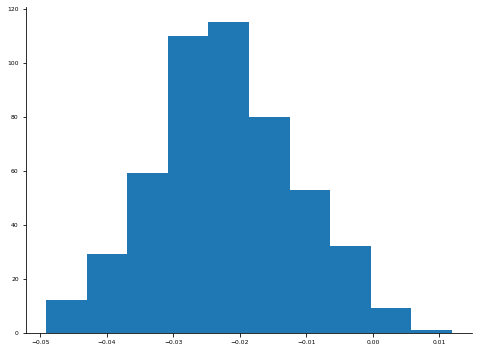

In [55]:
ic = get_bootstrapped_sample(ic, nboot=500, metric='mean')  # , metric='median'

plt.figure()
plt.hist(ic)


In [37]:

# bootstrap ICC task unique sign
d_ = df.loc[(df.area=='ICC') & df.sig_state]
ic = {s: (d_.loc[(d_.siteid==s), 'MI_task_unique']).values for s in d_.siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=500)
p = get_direct_prob(ic, np.zeros(ic.shape[0]))[0]
print(f"ICC task unique mean {d_['MI_task_unique'].median():.3f} n={d_['sig_state'].sum():.3f}")
print(f"    bootstrapped prob: {p:.3e}")
stat, p = sci.wilcoxon(d_['MI_task_unique'])
print(f'    Wilcoxon stat={stat:.3f}, p={p:.4e}')

# bootstrap ICC task unique sign
d_ = df.loc[(df.area=='ICX') & df.sig_state]
ic = {s: (d_.loc[(d_.siteid==s), 'MI_task_unique']).values for s in d_.siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=500)
p = 1- get_direct_prob(ic, np.zeros(ic.shape[0]))[0]
print(f"ICX task unique mean {d_['MI_task_unique'].median():.3f} n={d_['sig_state'].sum():.3f}")
print(f"    bootstrapped prob: {p:.3e}")
stat, p = sci.wilcoxon(d_['MI_task_unique'])
print(f'    Wilcoxon stat={stat:.3f}, p={p:.4e}')


# bootstrap A1 pupil unique sign
d_ = df.loc[df.isA1 & (df.sig_state)]
a1 = {s: (d_.loc[(d_.siteid==s), 'MI_pupil_unique']).values for s in d_.siteid.unique()}
a1 = get_bootstrapped_sample(a1, nboot=500)
p = get_direct_prob(a1, np.zeros(a1.shape[0]))[0]
print(f"\nA1 pupil unique mean {d_['MI_pupil_unique'].mean():.3f}")
print(f"    bootstrapped prob: {p:.3e}")

# bootstrap IC pupil unique sign
d_ = df.loc[~df.isA1 & df.sig_state]
ic = {s: (d_.loc[(d_.siteid==s), 'MI_pupil_unique']).values for s in d_.siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=500)
p = get_direct_prob(ic, np.zeros(ic.shape[0]))[0]
print(f"IC pupil unique mean {d_['MI_pupil_unique'].mean():.3f} n={d_['sig_state'].sum():.3f}")
print(f"    bootstrapped prob: {p:.3e}")


ICC task unique mean 0.012 n=13.000
    bootstrapped prob: 6.000e-03
    Wilcoxon stat=21.000, p=8.6860e-02
ICX task unique mean -0.049 n=36.000
    bootstrapped prob: 6.000e-03
    Wilcoxon stat=118.000, p=7.3075e-04

A1 pupil unique mean 0.038
    bootstrapped prob: 4.000e-02
IC pupil unique mean 0.022 n=49.000
    bootstrapped prob: 2.600e-02


In [121]:

# bootstrap A1 task vs. unique
d_ = df.loc[df.isA1 & (df.sig_task | df.sig_utask)]
a1 = {s: (d_.loc[(d_.siteid==s), 'abs_task']-d_.loc[(d_.siteid==s), 'abs_task_unique']).values for s in d_.siteid.unique()}
a1 = get_bootstrapped_sample(a1, nboot=2000)
p = get_direct_prob(a1, np.zeros(a1.shape[0]))[0]
print(f"\n A1 normed task vs. unique mean {d_['abs_task'].mean():.3f} vs. {d_['abs_task_unique'].mean():.3f}")
print(f"    bootstrapped prob: {p:.3e}")

# bootstrap IC task vs. unique
d_ = df.loc[~df.isA1 & (df.sig_task | df.sig_utask)]
ic = {s: (d_.loc[(d_.siteid==s), 'abs_task']-d_.loc[(d_.siteid==s), 'abs_task_unique']).values for s in d_.siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=2000)
p = get_direct_prob(ic, np.zeros(ic.shape[0]))[0]
print(f"\n IC normed task vs. unique mean {d_['abs_task'].mean():.3f} vs. {d_['abs_task_unique'].mean():.3f}")
print(f"    bootstrapped prob: {p:.3e}")

# bootstrap ICC task vs. unique
d_ = df.loc[(df.area=='ICC') & (df.sig_task | df.sig_utask)]
icc = {s: (d_.loc[(d_.siteid==s), 'abs_task']-d_.loc[(d_.siteid==s), 'abs_task_unique']).values for s in d_.siteid.unique()}
icc = get_bootstrapped_sample(icc, nboot=1000)

p = get_direct_prob(icc, np.zeros(ic.shape[0]))[0]
print(f"\n ICC normed task vs. unique mean {d_['abs_task'].mean():.3f} vs. {d_['abs_task_unique'].mean():.3f}")
print(f"    bootstrapped prob: {p:.3e}")

# bootstrap NCIC task vs. unique
d_ = df.loc[(df.area=='ICX') & (df.sig_task | df.sig_utask)]
icx = {s: (d_.loc[(d_.siteid==s), 'abs_task']-d_.loc[(d_.siteid==s), 'abs_task_unique']).values for s in d_.siteid.unique()}
icx = get_bootstrapped_sample(icx, nboot=1000)

p = get_direct_prob(icx, np.zeros(ic.shape[0]))[0]
print(f"\n NCIC normed task vs. unique mean {d_['abs_task'].mean():.3f} vs. {d_['abs_task_unique'].mean():.3f}")
print(f"    bootstrapped prob: {p:.3e}")

# bootstrap ICC vs NCIC delta
p = get_direct_prob(icc, icx)[0]
print(f"\n ICC vs. NCIC")
print(f"    bootstrapped prob: {p:.3e}")

# bootstrap A1 vs. IC task unique
a1 = {s: df.loc[(df.siteid==s), 'abs_task_unique'].values for s in df.loc[df.isA1].siteid.unique()}
a1 = get_bootstrapped_sample(a1, nboot=500)
ic = {s: df.loc[(df.siteid==s), 'abs_task_unique'].values for s in df.loc[~df.isA1].siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=500)
p = get_direct_prob(a1, ic)[0]
print(f"\nA1 v. IC normed task unique {df.loc[df.isA1,'abs_task_unique'].mean():.3f} vs. {df.loc[~df.isA1,'abs_task_unique'].mean():.3f}")
print(f"   bootstrapped prob: {p:.3e}")

# bootstrap A1 vs. IC pupil unique
a1 = {s: df.loc[(df.siteid==s), 'abs_pupil_unique'].values for s in df.loc[df.isA1].siteid.unique()}
a1 = get_bootstrapped_sample(a1, nboot=500)
ic = {s: df.loc[(df.siteid==s), 'abs_pupil_unique'].values for s in df.loc[~df.isA1].siteid.unique()}
ic = get_bootstrapped_sample(ic, nboot=500)
p = get_direct_prob(a1, ic)[0]
print(f"\nA1 v. IC normed pupil unique {df.loc[df.isA1,'abs_pupil_unique'].mean():.3f} vs. {df.loc[~df.isA1,'abs_pupil_unique'].mean():.3f}")
print(f"   bootstrapped prob: {p:.3e}")


 A1 normed task vs. unique mean 0.199 vs. 0.135
    bootstrapped prob: 5.000e-04

 IC normed task vs. unique mean 0.147 vs. 0.074
    bootstrapped prob: 1.400e-02

 ICC normed task vs. unique mean 0.089 vs. 0.054
    bootstrapped prob: 1.500e-02

 NCIC normed task vs. unique mean 0.160 vs. 0.078
    bootstrapped prob: 1.300e-02

 ICC vs. NCIC
    bootstrapped prob: 7.372e-01

A1 v. IC normed task unique 0.095 vs. 0.046
   bootstrapped prob: 5.480e-04


KeyError: 'abs_pupil_unique'

### FIGURE 6 (CRH results fine)

### FIGURE 7 (script Fig 6)

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-02-01 221829.log


[[0.123 0.183 0.009 0.029 0.022 0.651]
 [0.283 0.335 0.007 0.031 0.015 0.524]
 [0.503 0.544 0.012 0.016 0.013 0.348]
 [0.683 0.731 0.013 0.021 0.015 0.375]
 [0.88  0.904 0.007 0.014 0.004 0.625]]
[[0.115 0.203 0.01  0.03  0.048 0.594]
 [0.264 0.341 0.002 0.042 0.033 0.733]
 [0.513 0.576 0.001 0.037 0.024 0.5  ]
 [0.727 0.775 0.002 0.013 0.033 0.545]
 [0.87  0.886 0.001 0.01  0.005 0.455]]
['A1']
    r=-0.134, p=0.12508, pboot=0.12000
['ICC', 'ICX']
    r=-0.323, p=0.00254, pboot=0.00800
WARNING. Did not find tuning file(s) for this batch
WARNING. Did not find tuning file(s) for this batch
[[0.12  0.218 0.098 0.    0.    0.447]
 [0.299 0.349 0.05  0.    0.    0.341]
 [0.497 0.55  0.052 0.    0.    0.325]
 [0.712 0.743 0.03  0.    0.    0.37 ]
 [0.864 0.88  0.016 0.    0.    0.351]]
[[0.114 0.159 0.045 0.    0.    0.355]
 [0.286 0.329 0.043 0.    0.    0.353]
 [0.491 0.516 0.025 0.    0.    0.2  ]
 [0.68  0.715 0.036 0.    0.    0.263]
 [0.88  0.9   0.02  0.    0.    0.5  ]]


/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


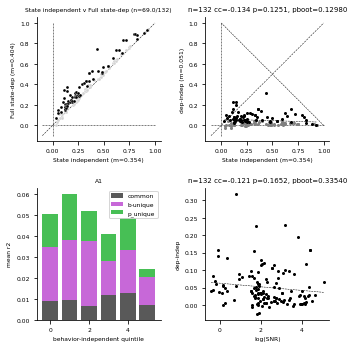

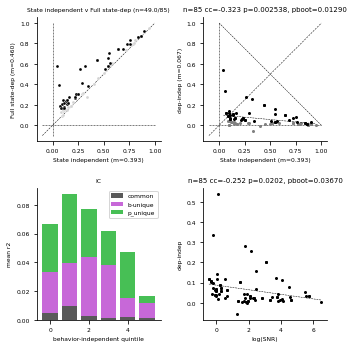

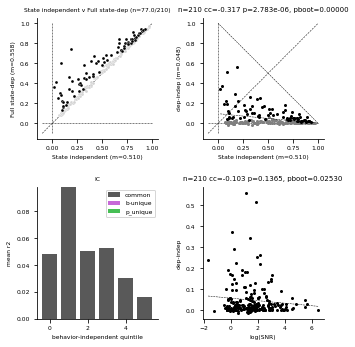

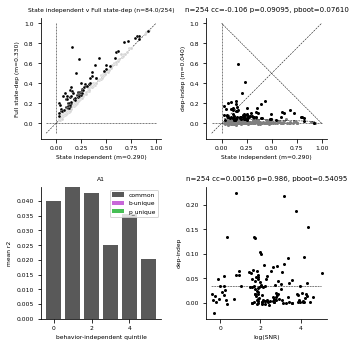

In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as ss

import statsmodels.formula.api as smf
import matplotlib.collections as clt
import re
import pylab as pl

from nems_lbhb.analysis.statistics import get_direct_prob, get_bootstrapped_sample
from nems_lbhb.pupil_behavior_scripts.mod_per_state import get_model_results_per_state_model
from nems_lbhb.pupil_behavior_scripts.mod_per_state import aud_vs_state
from nems_lbhb.pupil_behavior_scripts.mod_per_state import hlf_analysis
from nems_lbhb.pupil_behavior_scripts.mod_per_state import beh_only_plot
from nems_lbhb.stateplots import model_per_time_wrapper, beta_comp
import nems_lbhb.pupil_behavior_scripts.common as common
import nems_lbhb.pupil_behavior_scripts.helpers as helper
from nems import get_setting

# set path to dump file
dump_path = get_setting('NEMS_RESULTS_DIR')

save_path = os.path.join(os.path.expanduser('~'),'docs/current/pupil_behavior/eps')
save_fig = False

# ===================================================== pupil behavior data =======================================================
# SPECIFY models
USE_AFL = True
if USE_AFL:
    dump_results = 'd_pup_afl_sdexp.csv'
    model_string = 'st.pup.afl'
    p0_model = 'st.pup0.afl'
    b0_model = 'st.pup.afl0'
    shuf_model = 'st.pup0.afl0'
else:
    dump_results = 'd_pup_beh_sdexp.csv'
    model_string = 'st.pup.beh'
    p0_model = 'st.pup0.beh'
    b0_model = 'st.pup.beh0'
    shuf_model = 'st.pup0.beh0'

# set params for BF characterization and sig. sensory response threshold
octave_cutoff = 0.5
r0_threshold = 0
group_files = True
if 'stategain' in dump_results:
    preprocess_fn = helper.preprocess_stategain_dump
else:
    preprocess_fn = helper.preprocess_sdexp_dump

# import / preprocess model results
A1 = preprocess_fn(dump_results,
                    batch=307,
                    full_model=model_string,
                    p0=p0_model,
                    b0=b0_model,
                    shuf_model=shuf_model,
                    r0_threshold=r0_threshold,
                    octave_cutoff=octave_cutoff,
                    path=dump_path)
A1['area'] = 'A1'
IC = preprocess_fn(dump_results,
                    batch=309,
                    full_model=model_string,
                    p0=p0_model,
                    b0=b0_model,
                    shuf_model=shuf_model,
                    r0_threshold=r0_threshold,
                    octave_cutoff=octave_cutoff,
                    path=dump_path)
d_IC_area = pd.read_csv('IC_cells_area.csv', index_col=0)
IC = IC.merge(d_IC_area, on=['cellid'])

df = pd.concat([A1, IC])

if group_files & ('beh' not in model_string):
    area = df['area']
    df = df.groupby(by=['cellid', 'ON_BF']).mean()
    df['area'] = [area.loc[c] if type(area.loc[c]) is str else area.loc[c][0] for c in df.index.get_level_values('cellid')]

# 6A
norm_by_null=False
f = helper.aud_vs_state(df.loc[df.area=='A1'], nb=5, colors=common.color_list, title='A1', norm_by_null=norm_by_null)
if save_fig:
    f.savefig(os.path.join(save_path,'fig6_tuning_vs_pup_beh_A1.pdf'))

# 6B
f = helper.aud_vs_state(df.loc[df.area.isin(['ICC', 'ICX'])], nb=5, colors=common.color_list, title='IC', norm_by_null=norm_by_null)
if save_fig:
    f.savefig(os.path.join(save_path,'fig6_tuning_vs_pup_beh_IC.pdf'))

# compute stats -- null vs unique state prediction
np.random.seed(123)
df['siteid'] = [c[:7] for c in df.index.get_level_values(0)]
for area in [['A1'], ['ICC', 'ICX']]:
    am = df.area.isin(area)
    r, p = ss.pearsonr(df[am]['r_full'] - df[am]['r_shuff'], df[am]['r_shuff'])
    diff = {s: df[(df.siteid==s) & am]['r_full'].values - df[(df.siteid==s) & am]['r_shuff'].values 
                                        for s in df[am].siteid.unique()}
    null = {s: df[(df.siteid==s) & am]['r_shuff'].values for s in df[am].siteid.unique()}
    cc = get_bootstrapped_sample(diff, null, metric='corrcoef', nboot=1500)
    pboot = 1 - get_direct_prob(cc, np.zeros(cc.shape[0]))[0]
    print(f"{area}\n    r={r:.3f}, p={p:.5f}, pboot={pboot:.5f}")
# ==================================================== behavior only data ===========================================================
# Figures 6C-D  - beh only effects, bigger set of cells
# later figure -- beh only (ignore pupil, can use larger stim set)

# SPECIFY models
USE_AFL = True
if USE_AFL:
    dump_results = 'd_afl_sdexp.csv'
    model_string = 'st.afl'
    p0_model = None
    b0_model = 'st.afl0'
    shuf_model = 'st.afl0'
else:
    dump_results = 'd_beh_sdexp.csv'
    model_string = 'st.beh'
    p0_model = None
    b0_model = 'st.beh0'
    shuf_model = 'st.beh0'

# set params for BF characterization and sig. sensory response threshold
octave_cutoff = 0.5
r0_threshold = 0
group_files = True
if 'stategain' in dump_results:
    preprocess_fn = helper.preprocess_stategain_dump
else:
    preprocess_fn = helper.preprocess_sdexp_dump

# import / preprocess model results
A1 = []
for batch in [307, 311, 312]:
    _A1 = preprocess_fn(dump_results,
                        batch=batch,
                        full_model=model_string,
                        p0=p0_model,
                        b0=b0_model,
                        shuf_model=shuf_model,
                        r0_threshold=r0_threshold,
                        octave_cutoff=octave_cutoff,
                        path=dump_path)
    _A1['area'] = 'A1'
    A1.append(_A1)
A1 = pd.concat(A1)

IC = []
for batch in [295, 313]:
    _IC = preprocess_fn(dump_results,
                        batch=batch,
                        full_model=model_string,
                        p0=p0_model,
                        b0=b0_model,
                        shuf_model=shuf_model,
                        r0_threshold=r0_threshold,
                        octave_cutoff=octave_cutoff,
                        path=dump_path)
    _IC['area'] = 'IC'
    IC.append(_IC)
IC = pd.concat(IC)

df = pd.concat([A1, IC])

if group_files & ('beh' not in model_string):
    area = df['area']
    df = df.groupby(by=['cellid']).mean()
    df['area'] = [area.loc[c] if type(area.loc[c]) is str else area.loc[c][0] for c in df.index.get_level_values('cellid')]

f = helper.aud_vs_state(df.loc[df.area=='IC'], nb=5, state_list=['st.afl0', 'st.afl'], colors=common.color_list, title='IC', norm_by_null=norm_by_null)
if save_fig:
    f.savefig(os.path.join(save_path,'fig6_tuning_vs_beh_only_IC.pdf'))

f = helper.aud_vs_state(df.loc[df.area=='A1'], nb=5, state_list=['st.afl0', 'st.afl'], colors=common.color_list, title='A1', norm_by_null=norm_by_null)
if save_fig:
    f.savefig(os.path.join(save_path,'fig6_tuning_vs_beh_only_A1.pdf'))


### FIGURE 8 (post passive script Fig 7)

/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


 postall vs postu: Wilcoxon stat=1808.0 p=1.201e-03
 mean: 0.007 mean0: 0.019
Hierarchical bootstrap probability unique > block only: 0.0
raw:  [ 0.          0.16572077  0.00704023  0.13485951 -0.00979623]
u:  [0.         0.11317098 0.01143689 0.09916392 0.000742  ]


/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


 postall vs postu: Wilcoxon stat=298.0 p=9.394e-06
 mean: 0.047 mean0: 0.014
Hierarchical bootstrap probability unique > block only: 0.0
raw:  [0.         0.06642314 0.03743378 0.08509146 0.01875544]
u:  [0.         0.02075233 0.01490506 0.02997973 0.01015026]


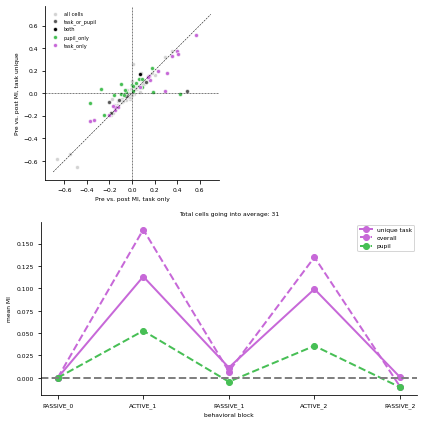

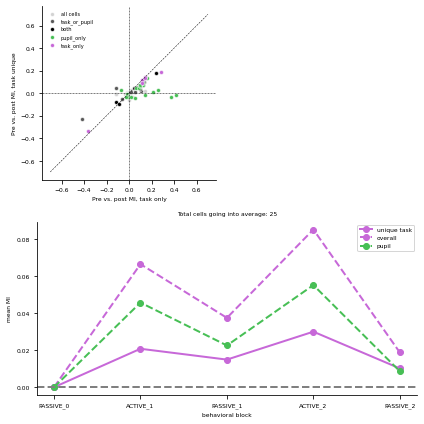

In [131]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as sci
import statsmodels.formula.api as smf
import matplotlib.collections as clt
import re
import pylab as pl

from nems_lbhb.pupil_behavior_scripts.mod_per_state import get_model_results_per_state_model
from nems_lbhb.pupil_behavior_scripts.mod_per_state import aud_vs_state
from nems_lbhb.pupil_behavior_scripts.mod_per_state import hlf_analysis
from nems_lbhb.pupil_behavior_scripts.mod_per_state import beh_only_plot
from nems_lbhb.stateplots import model_per_time_wrapper, beta_comp
from nems import get_setting
import nems_lbhb.pupil_behavior_scripts.common as common
import nems_lbhb.pupil_behavior_scripts.helpers as helper

save_path = os.path.join(os.path.expanduser('~'),'docs/current/pupil_behavior/eps')
save_fig = False


PAS_ONLY = True
sig_cells_only = True # if true, for the line plot, only average over cells with sig. state effects
dump_path = get_setting('NEMS_RESULTS_DIR')
basemodel = "-ref-psthfr.s_sdexp.S"
state_list = ['st.pup0.fil0', 'st.pup0.fil', 'st.pup.fil0', 'st.pup.fil']
states = ['PASSIVE_0',  'ACTIVE_1', 'PASSIVE_1',
        'ACTIVE_2', 'PASSIVE_2']

batch=307
A1 = pd.read_csv(os.path.join(dump_path, str(batch), 'd_pup_fil_sdexp.csv'))
# convert r values to numeric
try:
        A1['r'] = [np.float(r.strip('[]')) for r in A1['r'].values]
        A1['r_se'] = [np.float(r.strip('[]')) for r in A1['r_se'].values]
except:
        pass
A1 = A1[~A1.cellid.str.contains('AMT')]
batch=309
IC = pd.read_csv(os.path.join(dump_path, str(batch), 'd_pup_fil_sdexp.csv'))
# convert r values to numeric
try:
        IC['r'] = [np.float(r.strip('[]')) for r in IC['r'].values]
        IC['r_se'] = [np.float(r.strip('[]')) for r in IC['r_se'].values]
except:
        pass
IC = IC[~IC.cellid.str.contains('AMT')]

# load afl results to get list of sig cells
dump_results = 'd_pup_afl_sdexp.csv'
model_string = 'st.pup.afl'
p0_model = 'st.pup0.afl'
b0_model = 'st.pup.afl0'
shuf_model = 'st.pup0.afl0'
octave_cutoff = 0.5
r0_threshold = 0
group_files = True
A1_afl = helper.preprocess_sdexp_dump(dump_results,
                                  batch=307,
                                  full_model=model_string,
                                  p0=p0_model,
                                  b0=b0_model,
                                  shuf_model=shuf_model,
                                  r0_threshold=r0_threshold,
                                  octave_cutoff=octave_cutoff,
                                  path=dump_path)

task_only = A1_afl[A1_afl['sig_utask'] & ~A1_afl['sig_upupil']].index.unique().tolist()
pupil_only = A1_afl[~A1_afl['sig_utask'] & A1_afl['sig_upupil']].index.unique().tolist()
both = A1_afl[A1_afl['sig_utask'] & A1_afl['sig_upupil']].index.unique().tolist()
task_or_pupil = [c for c in A1_afl[A1_afl['sig_state']].index.unique() if \
                        (c not in task_only) & (c not in pupil_only) & (c not in both)] 
A1_sig = {'task_or_pupil': task_or_pupil, 'both': both, 'pupil_only': pupil_only, 'task_only': task_only}

IC_afl = helper.preprocess_sdexp_dump(dump_results,
                                  batch=309,
                                  full_model=model_string,
                                  p0=p0_model,
                                  b0=b0_model,
                                  shuf_model=shuf_model,
                                  r0_threshold=r0_threshold,
                                  octave_cutoff=octave_cutoff,
                                  path=dump_path)
task_only = IC_afl[IC_afl['sig_utask'] & ~IC_afl['sig_upupil']].index.unique().tolist()
pupil_only = IC_afl[~IC_afl['sig_utask'] & IC_afl['sig_upupil']].index.unique().tolist()
both = IC_afl[IC_afl['sig_utask'] & IC_afl['sig_upupil']].index.unique().tolist()
task_or_pupil = [c for c in IC_afl[IC_afl['sig_state']].index.unique() if \
                        (c not in task_only) & (c not in pupil_only) & (c not in both)] 
IC_sig = {'task_or_pupil': task_or_pupil, 'both': both, 'pupil_only': pupil_only, 'task_only': task_only}

if not PAS_ONLY:
        fA1, _1, _2 = helper.hlf_analysis(A1, state_list, norm_sign=True, sig_cells_only=sig_cells_only, states=states, scatter_sig_cells=A1_sig)

        fIC, _1, _2 = helper.hlf_analysis(IC, state_list, norm_sign=True, sig_cells_only=sig_cells_only, states=states, scatter_sig_cells=IC_sig)

else:
        # load pas only models
        batch=307
        A1_pas = pd.read_csv(os.path.join(dump_path, str(batch), 'd_pup_pas_sdexp.csv'))
        # convert r values to numeric
        try:
                A1_pas['r'] = [np.float(r.strip('[]')) for r in A1_pas['r'].values]
                A1_pas['r_se'] = [np.float(r.strip('[]')) for r in A1_pas['r_se'].values]
        except:
                pass
        A1_pas = A1_pas[~A1_pas.cellid.str.contains('AMT')]
        batch=309
        IC_pas = pd.read_csv(os.path.join(dump_path, str(batch), 'd_pup_pas_sdexp.csv'))
        # convert r values to numeric
        try:
                IC_pas['r'] = [np.float(r.strip('[]')) for r in IC_pas['r'].values]
                IC_pas['r_se'] = [np.float(r.strip('[]')) for r in IC_pas['r_se'].values]
        except:
                pass
        IC_pas = IC_pas[~IC_pas.cellid.str.contains('AMT')]

        # change task significance to be determined with the PAS model
        dump_results = 'd_pup_pas_sdexp.csv'
        model_string = 'st.pup.pas'
        p0_model = 'st.pup0.pas'
        b0_model = 'st.pup.pas0'
        shuf_model = 'st.pup0.pas0'
        octave_cutoff = 0.5
        r0_threshold = 0
        A1_afl = helper.preprocess_sdexp_dump(dump_results,
                                        batch=307,
                                        full_model=model_string,
                                        p0=p0_model,
                                        b0=b0_model,
                                        shuf_model=shuf_model,
                                        r0_threshold=r0_threshold,
                                        octave_cutoff=octave_cutoff,
                                        pas_model=True,
                                        path=dump_path)

        task_only = A1_afl[A1_afl['sig_utask'] & ~A1_afl['sig_upupil']].index.unique().tolist()
        pupil_only = A1_afl[~A1_afl['sig_utask'] & A1_afl['sig_upupil']].index.unique().tolist()
        both = A1_afl[A1_afl['sig_utask'] & A1_afl['sig_upupil']].index.unique().tolist()
        task_or_pupil = [c for c in A1_afl[A1_afl['sig_state']].index.unique() if \
                                (c not in task_only) & (c not in pupil_only) & (c not in both)] 
        A1_sig = {'task_or_pupil': task_or_pupil, 'both': both, 'pupil_only': pupil_only, 'task_only': task_only}

        IC_afl = helper.preprocess_sdexp_dump(dump_results,
                                        batch=309,
                                        full_model=model_string,
                                        p0=p0_model,
                                        b0=b0_model,
                                        shuf_model=shuf_model,
                                        r0_threshold=r0_threshold,
                                        octave_cutoff=octave_cutoff,
                                        pas_model=True,
                                        path=dump_path)
        task_only = IC_afl[IC_afl['sig_utask'] & ~IC_afl['sig_upupil']].index.unique().tolist()
        pupil_only = IC_afl[~IC_afl['sig_utask'] & IC_afl['sig_upupil']].index.unique().tolist()
        both = IC_afl[IC_afl['sig_utask'] & IC_afl['sig_upupil']].index.unique().tolist()
        task_or_pupil = [c for c in IC_afl[IC_afl['sig_state']].index.unique() if \
                                (c not in task_only) & (c not in pupil_only) & (c not in both)] 
        IC_sig = {'task_or_pupil': task_or_pupil, 'both': both, 'pupil_only': pupil_only, 'task_only': task_only}

        fA1, dMIu_A1, dMI_A1 = helper.hlf_analysis(A1, state_list, pas_df=A1_pas, norm_sign=True, sig_cells_only=sig_cells_only, states=states, scatter_sig_cells=A1_sig, bootstats=True)
        fIC, dMIu_IC, dMI_IC = helper.hlf_analysis(IC, state_list, pas_df=IC_pas, norm_sign=True, sig_cells_only=sig_cells_only, states=states, scatter_sig_cells=IC_sig, bootstats=True)

#stat, p = sci.wilcoxon(dMIu_A1, dMI_A1)


if save_fig:
    fA1.savefig(os.path.join(save_path,'fig7_pre_post_A1.pdf'))
    fIC.savefig(os.path.join(save_path,'fig7_pre_post_IC.pdf'))


### FIGURE 1

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import os
import io
import pandas as pd

#import nems.recording
import nems.modelspec as ms
import nems.xforms as xforms
import nems.xform_helper as xhelp
import nems.utils
import nems.db as nd
import nems.recording as recording
import nems.epoch as ep

#import nems.baphy as nb
import nems_lbhb.xform_wrappers as nw
import nems_lbhb.stateplots as sp
from nems_lbhb.analysis.statistics import get_bootstrapped_sample, get_direct_prob

#params = {'legend.fontsize': 8,
#          'figure.figsize': (8, 6),
#          'axes.labelsize': 8,
#          'axes.titlesize': 8,
#          'xtick.labelsize': 8,
#          'ytick.labelsize': 8,
#          'pdf.fonttype': 42,
#          'ps.fonttype': 42}
#plt.rcParams.update(params)


def ev_pupil(cellid, batch, presilence=0.35):
    modelname = "psth.fs20.pup-st.pup.beh_stategain.3_init.st-basic"

    print('Finding recording for cell/batch {0}/{1}...'.format(cellid, batch))

    # parse modelname
    kws = modelname.split("_")
    loader = kws[0]
    modelspecname = "_".join(kws[1:-1])
    fitkey = kws[-1]

    # generate xfspec, which defines sequence of events to load data,
    # generate modelspec, fit data, plot results and save
    recording_uri = nw.generate_recording_uri(cellid, batch, loader)
    print(recording_uri)

    rec = recording.load_recording(recording_uri)
    pupil = rec['pupil']
    active = pupil.epoch_to_signal('ACTIVE_EXPERIMENT')
    active.chans = ['active']

    p = pupil.as_continuous()[0, :]
    b = active.as_continuous()[0, :]
    g = np.isfinite(p) & np.isfinite(b)
    cc_pup_beh = np.corrcoef(p[g], b[g])[0, 1]

    pshift = np.int(pupil.fs * 0.75)
    #pupil = pupil._modified_copy(np.roll(pupil._data, (0, pshift)))
    d = pupil._data
    pupil = pupil._modified_copy(np.roll(d / np.nanmax(d), (0, pshift)))
    #pupil = pupil._modified_copy(d / np.nanmax(d))
    #pupil = pupil._modified_copy(np.roll(d, (0, pshift)))

    trials = pupil.get_epoch_indices('TRIAL')
    targets = pupil.get_epoch_indices('TARGET')
    #pt_blocks = pupil.get_epoch_indices('PURETONE_BEHAVIOR').tolist()
    pt_blocks = pupil.get_epoch_indices('ACTIVE_EXPERIMENT').tolist()
    easy_blocks = pupil.get_epoch_indices('EASY_BEHAVIOR').tolist()
    hard_blocks = pupil.get_epoch_indices('HARD_BEHAVIOR').tolist()
    passive_blocks = pupil.get_epoch_indices('PASSIVE_EXPERIMENT').tolist()
    behavior_blocks = pupil.get_epoch_indices('ACTIVE_EXPERIMENT')

    blocks=[]
    for p in passive_blocks:
        p.append('passive')
        blocks.append(p)
    for p in pt_blocks:
        p.append('puretone')
        blocks.append(p)
    for p in easy_blocks:
        p.append('easy')
        blocks.append(p)
    for p in hard_blocks:
        p.append('hard')
        blocks.append(p)

    blocks.sort()
    #print(blocks)
    trialbins = int(pupil.fs * 5)  # was 6
    prebins = int(pupil.fs *presilence)

    ev=[]
    ev_prenorm=[]
    label=[]
    beh_lickrate=[]
    beh_lickrate_norm=[]
    beh_all = {}
    for block in blocks:
        k = block[-1]
        label.append(k)
        block_trials = ep.epoch_intersection(trials, np.array([block[0:2]]))
        tcount=block_trials.shape[0]
        for t in range(tcount):
            block_trials[t,1]=block_trials[t,0]+trialbins
            if block_trials[t,1]>pupil.shape[1]:
                block_trials[t,1]=pupil.shape[1]

        tev = pupil.extract_epoch(block_trials)[:,0,:]

        tev0 = np.nanmean(tev[:,:prebins],axis=1)
#        m = tev0 > 0.3 * np.nanmax(tev0)
#        print(block)
#        print("{}-{} mean {} ({}/{} big)".format(
#                np.nanmin(tev0),np.nanmax(tev0),np.nanmean(tev0),
#                np.sum(m), len(tev0)))
#        tev = tev[m, :]

        ev.append(tev)
        ev_prenorm.append(tev - np.mean(tev[:,:prebins],axis=1,keepdims=True))
        if k not in beh_all.keys():
            beh_all[k]=np.array([])
        beh_all[k] = np.append(beh_all[k], tev.ravel())
        beh_lickrate.append((k,np.nanmean(ev[-1],axis=0)))
        beh_lickrate_norm.append((k,np.nanmean(ev_prenorm[-1],axis=0)))

        #print("{}: {} trials, {} bins".format(k,tev.shape[0],tev.shape[1]))

    perf_blocks={'hits': pupil.get_epoch_indices('HIT_TRIAL'),
                 'misses': pupil.get_epoch_indices('MISS_TRIAL'),
                 'fas': pupil.get_epoch_indices('FA_TRIAL')}

    ev=[]
    ev_prenorm=[]
    perf_lickrate=[]
    perf_lickrate_norm=[]
    perf_all = {}
    for k,block in perf_blocks.items():

        block_trials = ep.epoch_intersection(trials, block)
        tcount=block_trials.shape[0]
        for t in range(tcount):
            block_trials[t,1]=block_trials[t,0]+trialbins
            if block_trials[t,1]>pupil.shape[1]:
                block_trials[t,1]=pupil.shape[1]
        t = pupil.extract_epoch(block_trials, allow_empty=True)
        if t.size:
            tev = t[:,0,:]
        else:
            tev = np.ones((1,trialbins)) * np.nan
        perf_all[k] = t.ravel()

        ev.append(tev)
        ev_prenorm.append(tev - np.mean(tev[:,:prebins],axis=1,keepdims=True))

        perf_lickrate.append((k,np.nanmean(ev[-1],axis=0)))
        perf_lickrate_norm.append((k,np.nanmean(ev_prenorm[-1],axis=0)))

        #print("{}: {} trials, {} bins".format(k,tev.shape[0],tev.shape[1]))

    return beh_lickrate, beh_lickrate_norm, beh_all, \
           perf_lickrate, perf_lickrate_norm, perf_all, cc_pup_beh


def ev_pupil_plot(ev_data_tuple_list, title=None, ax=None, fs=100,
                  prestimsilence=0.35, linecolors=None, fillcolors=None):
    if ax is None:
        fh=plt.figure()
        ax=plt.gca()
    trialbins=len(ev_data_tuple_list[0][1])
    tt=np.arange(trialbins) / fs - prestimsilence

    label=[]
    cc=0
    opt={}
    for k, ev in ev_data_tuple_list:
        label.append(k)
        if len(ev.shape)>1 and ev.shape[1]>1:
            if fillcolors is not None:
                opt = {'facecolor': fillcolors[cc], 'alpha': 0.5}
            mm=np.nanmean(ev,axis=1)
            ee=np.nanstd(ev,axis=1)/np.sqrt(ev.shape[1])
            plt.fill_between(tt, mm-ee, mm+ee, **opt)
        else:
            mm = ev
        if linecolors is not None:
            opt = {'color': linecolors[cc]}
        plt.plot(tt, mm, **opt)
        cc += 1
    plt.legend(label, loc='upper left', frameon=False)
    plt.xlabel('trial time (s)')
    plt.ylabel('pupil diameter')
    if title is not None:
        plt.title(title)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return ax


# being main script
save_figures = False

batch = 307
d=nd.get_batch_cells(batch=batch)
cellids=list(d['cellid'])

ucellids=[cellids[0]]
batches=[batch]
for c in cellids[1:]:
    site1=ucellids[-1].split("-")[0]
    site2=c.split("-")[0]
    if site1 != site2:
        ucellids.append(c)
        batches.append(batch)

batch=309
d = nd.get_batch_cells(batch=batch)
cellids = list(d['cellid'])

for c in cellids[1:]:
    site1 = ucellids[-1].split("-")[0]
    site2 = c.split("-")[0]
    if site1 != site2:
        ucellids.append(c)
        batches.append(batch)

cellids = ucellids
print(cellids)
print(batches)

siteids=[]
active=[]
passive=[]
active_full=[]
passive_full=[]
hard=[]
easy=[]
puretone=[]
hits=[]
fas=[]
misses=[]
hits_full=[]
fas_full=[]
misses_full=[]
presilence=0.35
fs=20
perf_all={}
beh_all={}
cc_pup_beh = []
for cellid,batch in zip(cellids,batches):

    beh_lickrate, beh_lickrate_norm, tbeh_all, \
    perf_lickrate, perf_lickrate_norm, tperf_all, ccpb = \
         ev_pupil(cellid, batch, presilence=presilence)

    siteids.append(cellid.split("-")[0])
    cc_pup_beh.append(ccpb)

    cc=0
    pset=[]
    aset=[]
    pfullset=[]
    afullset=[]
    for k, ev in beh_lickrate_norm:
        if k=='passive':
            pset.append(np.reshape(ev,[-1,1]))
            pfullset.append(np.reshape(beh_lickrate[cc][1],[-1,1]))
            kalt='passive'
        else:
            aset.append(np.reshape(ev,[-1,1]))
            afullset.append(np.reshape(beh_lickrate[cc][1],[-1,1]))
            if k=='hard':
                hard.append(np.reshape(ev,[-1,1]))
            elif k=='easy':
                easy.append(np.reshape(ev,[-1,1]))
            else:
                puretone.append(np.reshape(ev,[-1,1]))
            kalt='active'

        t = tbeh_all[k]
        t = t[np.isfinite(t)]
        if kalt in beh_all.keys():
            beh_all[kalt] = np.append(beh_all[kalt], t)
        else:
            beh_all[kalt] = t

        cc+=1

    passive.append(np.mean(np.concatenate(pset,axis=1),axis=1, keepdims=True))
    passive_full.append(np.mean(np.concatenate(pfullset,axis=1),axis=1, keepdims=True))
    active.append(np.mean(np.concatenate(aset,axis=1),axis=1, keepdims=True))
    active_full.append(np.mean(np.concatenate(afullset,axis=1),axis=1, keepdims=True))

    cc=0
    for k, ev in perf_lickrate_norm:
        if k=='hits':
            hits.append(np.reshape(ev,[-1,1]))
            hits_full.append(np.reshape(perf_lickrate[cc][1],[-1,1]))
        elif k=='misses':
            misses.append(np.reshape(ev,[-1,1]))
            misses_full.append(np.reshape(perf_lickrate[cc][1],[-1,1]))
        else:
            fas.append(np.reshape(ev,[-1,1]))
            fas_full.append(np.reshape(perf_lickrate[cc][1],[-1,1]))
        cc+=1

        t = tperf_all[k]
        t = t[np.isfinite(t)]
        if cellid==cellids[0]:
            perf_all[k] = t
        else:
            perf_all[k] = np.append(perf_all[k],t)



[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/AMT018a_0c7b41bb773433ca12df509de0048c3300f22e15.tgz


['AMT018a-01-1', 'AMT020a-18-1', 'AMT022c-02-1', 'AMT026a-04-2', 'bbl102d-01-1', 'BRT026c-02-1', 'BRT033b-02-1', 'BRT034f-02-1', 'BRT036b-01-1', 'BRT037b-01-1', 'BRT039c-03-1', 'TAR010c-01-1', 'bbl071d-a2', 'bbl074g-a1', 'bbl078k-a1', 'bbl081d-a1', 'BRT005c-a1', 'BRT006d-a1', 'BRT007c-a1', 'BRT009a-a1', 'BRT009c-a1', 'BRT009d-a1', 'BRT015b-a1', 'BRT015c-a1', 'BRT016f-a1', 'BRT017g-a1', 'ley011c-a1', 'ley026g-a1', 'ley027f-a1', 'ley027g-a1', 'ley034g-a1', 'ley035c-a1', 'ley040j-a1', 'ley040k-a1', 'ley041l-a1', 'ley042i-a1', 'ley046f-01-1', 'ley046g-04-1', 'ley049h-a1']
[307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309]
Finding recording for cell/batch AMT018a-01-1/307...
/auto/data/nems_db/recordings/307/AMT018a_0c7b41bb773433ca12df509de0048c3300f22e15.tgz


/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: Mean of empty slice
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: Mean of empty slice
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/AMT020a_f3f49e0bc28955eb54a6a85f9c7b9dd1f4f8ce76.tgz


Finding recording for cell/batch AMT020a-18-1/307...
/auto/data/nems_db/recordings/307/AMT020a_f3f49e0bc28955eb54a6a85f9c7b9dd1f4f8ce76.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/AMT022c_ac6bdb553d772051f27159392d9a8393f6d3ef4a.tgz


Finding recording for cell/batch AMT022c-02-1/307...
/auto/data/nems_db/recordings/307/AMT022c_ac6bdb553d772051f27159392d9a8393f6d3ef4a.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/AMT026a_b07305f33578ee80949db2ba0f4687f6667aa573.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup


Finding recording for cell/batch AMT026a-04-2/307...
/auto/data/nems_db/recordings/307/AMT026a_b07305f33578ee80949db2ba0f4687f6667aa573.tgz
Finding recording for cell/batch bbl102d-01-1/307...


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/bbl102d_93e31afdc8ad0b4fa22f8890680776822bb8f186.tgz


/auto/data/nems_db/recordings/307/bbl102d_93e31afdc8ad0b4fa22f8890680776822bb8f186.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/BRT026c_6f96db9eded4c11fbfa35d587f4f4c589fb56798.tgz


Finding recording for cell/batch BRT026c-02-1/307...
/auto/data/nems_db/recordings/307/BRT026c_6f96db9eded4c11fbfa35d587f4f4c589fb56798.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/BRT033b_ca408d910e22e5d5a0f0376cd858df14c824a47e.tgz


Finding recording for cell/batch BRT033b-02-1/307...
/auto/data/nems_db/recordings/307/BRT033b_ca408d910e22e5d5a0f0376cd858df14c824a47e.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/BRT034f_85c6fad89d33eda10be43f77b17980b3e972b308.tgz


Finding recording for cell/batch BRT034f-02-1/307...
/auto/data/nems_db/recordings/307/BRT034f_85c6fad89d33eda10be43f77b17980b3e972b308.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/BRT036b_e1a828343d812629f0fab88d4dce5650422e53bc.tgz


Finding recording for cell/batch BRT036b-01-1/307...
/auto/data/nems_db/recordings/307/BRT036b_e1a828343d812629f0fab88d4dce5650422e53bc.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/BRT037b_0c91f09755c537269ea54e9cd9545595156792f8.tgz


Finding recording for cell/batch BRT037b-01-1/307...
/auto/data/nems_db/recordings/307/BRT037b_0c91f09755c537269ea54e9cd9545595156792f8.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/BRT039c_91bee47f7add0c8c5a83818804e7b62987831f4f.tgz


Finding recording for cell/batch BRT039c-03-1/307...
/auto/data/nems_db/recordings/307/BRT039c_91bee47f7add0c8c5a83818804e7b62987831f4f.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/307/TAR010c_47d30af787b60e88eb761318bd74150a61045c41.tgz


Finding recording for cell/batch TAR010c-01-1/307...
/auto/data/nems_db/recordings/307/TAR010c_47d30af787b60e88eb761318bd74150a61045c41.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/bbl071d_cf277c267aa4b2a9c8c10787a9b24bb038a71a71.tgz


Finding recording for cell/batch bbl071d-a2/309...
/auto/data/nems_db/recordings/309/bbl071d_cf277c267aa4b2a9c8c10787a9b24bb038a71a71.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/bbl074g_56a02419289cad1c5d871feb520d4033a7e2b9a2.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup


Finding recording for cell/batch bbl074g-a1/309...
/auto/data/nems_db/recordings/309/bbl074g_56a02419289cad1c5d871feb520d4033a7e2b9a2.tgz
Finding recording for cell/batch bbl078k-a1/309...


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/bbl078k_7e8af9969f7b6d0e339056d63a0ece34a8c4e0ea.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/bbl081d_b0674be64e7cd4b60c143e7e710117c70efb6979.tgz


/auto/data/nems_db/recordings/309/bbl078k_7e8af9969f7b6d0e339056d63a0ece34a8c4e0ea.tgz
Finding recording for cell/batch bbl081d-a1/309...
/auto/data/nems_db/recordings/309/bbl081d_b0674be64e7cd4b60c143e7e710117c70efb6979.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/BRT005c_806e78cdeb9102b702308bf2b36b8deaced16788.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm


Finding recording for cell/batch BRT005c-a1/309...
/auto/data/nems_db/recordings/309/BRT005c_806e78cdeb9102b702308bf2b36b8deaced16788.tgz
Finding recording for cell/batch BRT006d-a1/309...


[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/BRT006d_1b03aff56c2fe3a21092c3c43ace489dab579f9a.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/BRT007c_4bd83d4ff6208deb3ebcc92694e84528f08f84a1.tgz


/auto/data/nems_db/recordings/309/BRT006d_1b03aff56c2fe3a21092c3c43ace489dab579f9a.tgz
Finding recording for cell/batch BRT007c-a1/309...
/auto/data/nems_db/recordings/309/BRT007c_4bd83d4ff6208deb3ebcc92694e84528f08f84a1.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/BRT009a_1a8a9d0c5709af12f2828bcd108cd92d67180fb9.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/BRT009c_1d7d720ea3a49487ea72523ea891aa0c79fc64f4.tgz


Finding recording for cell/batch BRT009a-a1/309...
/auto/data/nems_db/recordings/309/BRT009a_1a8a9d0c5709af12f2828bcd108cd92d67180fb9.tgz
Finding recording for cell/batch BRT009c-a1/309...
/auto/data/nems_db/recordings/309/BRT009c_1d7d720ea3a49487ea72523ea891aa0c79fc64f4.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/BRT009d_b4f378e54c774b82b635de015e0ae70aa45313ec.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/BRT015b_ac2272f031a3e80eb0aa419ae7fa080d33ba433b.tgz


Finding recording for cell/batch BRT009d-a1/309...
/auto/data/nems_db/recordings/309/BRT009d_b4f378e54c774b82b635de015e0ae70aa45313ec.tgz
Finding recording for cell/batch BRT015b-a1/309...
/auto/data/nems_db/recordings/309/BRT015b_ac2272f031a3e80eb0aa419ae7fa080d33ba433b.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/BRT015c_a635f2180fb5db898bd73ec1413d1f0c1fab0b9e.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup


Finding recording for cell/batch BRT015c-a1/309...
/auto/data/nems_db/recordings/309/BRT015c_a635f2180fb5db898bd73ec1413d1f0c1fab0b9e.tgz
Finding recording for cell/batch BRT016f-a1/309...


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/BRT016f_b727af0c691afd0427b285867082ab55f19d9799.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup


/auto/data/nems_db/recordings/309/BRT016f_b727af0c691afd0427b285867082ab55f19d9799.tgz
Finding recording for cell/batch BRT017g-a1/309...


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/BRT017g_fb461313032f3dd0a36f6e398c9e610fe8d89348.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley011c_8f19e41f44c5524a2622a0c8734f7fa9f0b4699b.tgz


/auto/data/nems_db/recordings/309/BRT017g_fb461313032f3dd0a36f6e398c9e610fe8d89348.tgz
Finding recording for cell/batch ley011c-a1/309...
/auto/data/nems_db/recordings/309/ley011c_8f19e41f44c5524a2622a0c8734f7fa9f0b4699b.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley026g_c816fd72a3e7518ca597c1a2aaf4e7b109757202.tgz
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley027f_5bb09fa11e257d78b7244f7997f9b07d6c85c0a2.tgz


Finding recording for cell/batch ley026g-a1/309...
/auto/data/nems_db/recordings/309/ley026g_c816fd72a3e7518ca597c1a2aaf4e7b109757202.tgz
Finding recording for cell/batch ley027f-a1/309...
/auto/data/nems_db/recordings/309/ley027f_5bb09fa11e257d78b7244f7997f9b07d6c85c0a2.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley027g_839d76200e4350ca64efd8ba7a9ed0f01b0feff5.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley034g_14da4f987b7647cfb829243b7b64794d865184e8.tgz


Finding recording for cell/batch ley027g-a1/309...
/auto/data/nems_db/recordings/309/ley027g_839d76200e4350ca64efd8ba7a9ed0f01b0feff5.tgz
Finding recording for cell/batch ley034g-a1/309...
/auto/data/nems_db/recordings/309/ley034g_14da4f987b7647cfb829243b7b64794d865184e8.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley035c_3365ded20556893164156b5aea4a32b3f0e1cdb4.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley040j_3aff017db82dd3a19296bacba6dd8733df5c6022.tgz


Finding recording for cell/batch ley035c-a1/309...
/auto/data/nems_db/recordings/309/ley035c_3365ded20556893164156b5aea4a32b3f0e1cdb4.tgz
Finding recording for cell/batch ley040j-a1/309...
/auto/data/nems_db/recordings/309/ley040j_3aff017db82dd3a19296bacba6dd8733df5c6022.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley040k_5aaf059e3edf66cb9f6ae93b7020c49ba16d880a.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley041l_d80be9033a14317a96d4cb2ebb1041834048aac3.tgz


Finding recording for cell/batch ley040k-a1/309...
/auto/data/nems_db/recordings/309/ley040k_5aaf059e3edf66cb9f6ae93b7020c49ba16d880a.tgz
Finding recording for cell/batch ley041l-a1/309...
/auto/data/nems_db/recordings/309/ley041l_d80be9033a14317a96d4cb2ebb1041834048aac3.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley042i_6f4f12346826be2087077301b57f231c9be6f8fb.tgz
[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup


Finding recording for cell/batch ley042i-a1/309...
/auto/data/nems_db/recordings/309/ley042i_6f4f12346826be2087077301b57f231c9be6f8fb.tgz
Finding recording for cell/batch ley046f-01-1/309...


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley046f_4f8abd897b1a25e53a1d161f11c2ce955432288a.tgz


/auto/data/nems_db/recordings/309/ley046f_4f8abd897b1a25e53a1d161f11c2ce955432288a.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley046g_6d404096d17ff9e4c182ff317dd6a2280832800a.tgz


Finding recording for cell/batch ley046g-04-1/309...
/auto/data/nems_db/recordings/309/ley046g_6d404096d17ff9e4c182ff317dd6a2280832800a.tgz


[nems_lbhb.xform_wrappers INFO] loader=psth.fs20.pup
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=parm
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/309/ley049h_8acbcec7f4e040009091713620adf6c24ca476ba.tgz


Finding recording for cell/batch ley049h-a1/309...
/auto/data/nems_db/recordings/309/ley049h_8acbcec7f4e040009091713620adf6c24ca476ba.tgz


7
Averaging evoked response over 0.0-3.0 sec
(39,)
(39,)


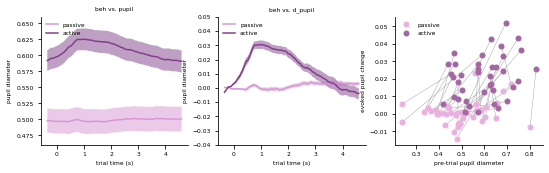

In [68]:
ylim1 = [0.46, 0.66]
ylim2 = [-0.04, 0.05]

f=plt.figure(figsize=(9,8))
ax=plt.subplot(3,3,1)
d=[('passive',np.concatenate(passive_full,axis=1)),
   ('active',np.concatenate(active_full,axis=1))]
ev_pupil_plot(d, title="beh vs. pupil", fs=fs, prestimsilence=presilence,
              ax=ax,
              linecolors=[sp.line_colors['passive'],sp.line_colors['active']],
              fillcolors=[sp.line_colors['passive'],sp.line_colors['active']])
ax.set_ylim(ylim1)

ax=plt.subplot(3,3,2)
d=[('passive',np.concatenate(passive,axis=1)),
   ('active',np.concatenate(active,axis=1))]
ev_pupil_plot(d, title="beh vs. d_pupil", fs=fs, prestimsilence=presilence,
              ax=ax,
              linecolors=[sp.line_colors['passive'],sp.line_colors['active']],
              fillcolors=[sp.line_colors['passive'],sp.line_colors['active']])
ax.set_ylim(ylim2)

prebins=int(presilence*fs)
print(prebins)
ev_start=int(presilence*fs)
ev_end=int((presilence+3)*fs)
print("Averaging evoked response over {}-{} sec".format(ev_start/fs-presilence, ev_end/fs-presilence))

passive_d=np.mean(np.concatenate(passive,axis=1)[ev_start:ev_end,:],axis=0)
passive_0=np.mean(np.concatenate(passive_full,axis=1)[:prebins,:],axis=0)

active_d=np.mean(np.concatenate(active,axis=1)[ev_start:ev_end,:],axis=0)
active_0=np.mean(np.concatenate(active_full,axis=1)[:prebins,:],axis=0)
print(passive_d.shape)
print(active_d.shape)

ax=plt.subplot(3,3,3)
for i in range(len(passive_0)):
    plt.plot([passive_0[i],active_0[i]],[passive_d[i],active_d[i]],
             color='darkgray',linewidth=0.5)

h1,=plt.plot(passive_0,passive_d,'.',markersize=10, label='passive',
             mfc=sp.fill_colors['passive'], mec=sp.fill_colors['passive'])
h2,=plt.plot(active_0,active_d,'.',markersize=10, label='active',
             mfc=sp.fill_colors['active'], mec=sp.fill_colors['active'])
plt.xlabel('pre-trial pupil diameter')
plt.ylabel('evoked pupil change')
plt.legend(handles=(h1,h2), frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: Mean of empty slice
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: Mean of empty slice
/home/svd/bin/miniconda3/envs/tfg/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(39,)
(39,)


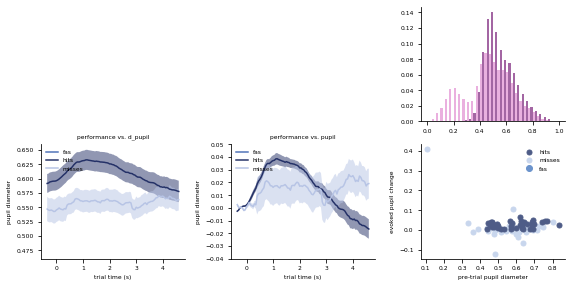

In [69]:
calc_diff=False
if calc_diff:
    ax=plt.subplot(3,3,5)
    d=[('hard',np.concatenate(hard,axis=1)),
       ('easy',np.concatenate(easy,axis=1)),
       ('puretone',np.concatenate(puretone,axis=1))]
    lc=[sp.line_colors['hard'],sp.line_colors['easy'],sp.line_colors['puretone']]
    fc=[sp.fill_colors['hard'],sp.fill_colors['easy'],sp.fill_colors['puretone']]

    ev_pupil_plot(d, title="difficulty vs. d_pupil", fs=fs, prestimsilence=presilence,
                  linecolors=lc, fillcolors=lc, ax=ax)
    ax.set_ylim(ylim2)

ax=plt.subplot(3,3,6)
b = np.linspace(0,1,31)
w = (b[1]-b[0])/2
x = b[1:]-w
p = np.histogram(beh_all['passive'], bins=b)[0]
p = p / np.sum(p)
a = np.histogram(beh_all['active'], bins=b)[0]
a = a / np.sum(a)

ax.bar(x-w/2, p, width=w, color=sp.fill_colors['passive'])
ax.bar(x+w/2, a, width=w, color=sp.fill_colors['active'])

lc=[sp.line_colors['false_alarm'],sp.line_colors['hit'],sp.line_colors['miss']]
fc=[sp.fill_colors['false_alarm'],sp.fill_colors['hit'],sp.fill_colors['miss']]

ax=plt.subplot(3,3,7)
d=[('fas',np.concatenate(fas_full,axis=1)),
   ('hits',np.concatenate(hits_full,axis=1)),
   ('misses',np.concatenate(misses_full,axis=1))]
ev_pupil_plot(d, title="performance vs. d_pupil", fs=fs, prestimsilence=presilence,
              linecolors=lc, fillcolors=lc, ax=ax)
ax.set_ylim(ylim1)

ax=plt.subplot(3,3,8)
d=[('fas',np.concatenate(fas,axis=1)),
   ('hits',np.concatenate(hits,axis=1)),
   ('misses',np.concatenate(misses,axis=1))]
ev_pupil_plot(d, title="performance vs. pupil", fs=fs, prestimsilence=presilence,
              linecolors=lc, fillcolors=lc, ax=ax)
ax.set_ylim(ylim2)


prebins=int(presilence*fs)
evbins=prebins+int(fs)  # look at first second post trial start

hits_d=np.mean(np.concatenate(hits,axis=1)[ev_start:ev_end,:],axis=0)
hits_0=np.mean(np.concatenate(hits_full,axis=1)[:prebins,:],axis=0)
misses_d=np.mean(np.concatenate(misses,axis=1)[ev_start:ev_end,:],axis=0)
misses_0=np.mean(np.concatenate(misses_full,axis=1)[:prebins,:],axis=0)
fas_d=np.mean(np.concatenate(fas,axis=1)[ev_start:ev_end,:],axis=0)
fas_0=np.mean(np.concatenate(fas_full,axis=1)[:prebins,:],axis=0)

print(hits_d.shape)
print(fas_d.shape)

ax=plt.subplot(3,3,9)
#for i in range(len(passive_0)):
#    plt.plot([passive_0[i],active_0[i]],[passive_d[i],active_d[i]],color='darkgray',linewidth=0.5)

h3,=plt.plot(fas_0, fas_d,'.',markersize=12, label='fas',
             mfc=sp.fill_colors['false_alarm'], mec=sp.fill_colors['false_alarm'])
h2,=plt.plot(misses_0, misses_d,'.',markersize=10, label='misses',
             mfc=sp.fill_colors['miss'], mec=sp.fill_colors['miss'])
h1,=plt.plot(hits_0, hits_d,'.',markersize=10, label='hits',
             mfc=sp.fill_colors['hit'], mec=sp.fill_colors['hit'])
plt.xlabel('pre-trial pupil diameter')
plt.ylabel('evoked pupil change')
plt.legend(handles=(h1,h2,h3), frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()

if save_figures:
    f.savefig('/auto/users/svd/projects/pupil-behavior/PTD_ev_pupil_sharpened.pdf')
    f.savefig('/auto/users/svd/projects/pupil-behavior/PTD_ev_pupil_sharpened.png')

    df=pd.DataFrame(data=np.vstack([passive_0, active_0, passive_d, active_d, cc_pup_beh]).T,
                    columns=['baseline_p','baseline_a','evoked_p','evoked_a', 'cc_pup_beh'],
                    index=siteids)
    df.to_csv('/auto/users/svd/projects/pupil-behavior/PTD_ev_pupil.per_site.csv')


In [72]:
df = pd.DataFrame({'cellid': cellids, 'passive_0': passive_0, 'passive_d': passive_d,
                  'active_0': active_0, 'active_d': active_d,
                  'hits_0': hits_0, 'hits_d': hits_d, 
                  'misses_0': misses_0, 'misses_d': misses_d, 
                  'fas_0': fas_0, 'fas_d': fas_d, 
                  })
df['siteid']=df.cellid.str.slice(0,3)

pas = {s: (df.loc[(df.siteid==s), 'passive_0']).values for s in df.siteid.unique()}
act = {s: (df.loc[(df.siteid==s), 'active_0']).values for s in df.siteid.unique()}
p_ = get_bootstrapped_sample(pas, nboot=500)
a_ = get_bootstrapped_sample(act, nboot=500)
p = get_direct_prob(a_, p_)[0]
print(f'pas0 vs. act0 {passive_0.mean():.3f} v {active_0.mean():.3f} hierarchical bootstrap: {p:.3e}')

pas = {s: (df.loc[(df.siteid==s), 'passive_d']).values for s in df.siteid.unique()}
act = {s: (df.loc[(df.siteid==s), 'active_d']).values for s in df.siteid.unique()}
p_ = get_bootstrapped_sample(pas, nboot=500)
a_ = get_bootstrapped_sample(act, nboot=500)
p = get_direct_prob(a_, p_)[0]
print(f'pasd vs. actd {passive_d.mean():.3f} v {active_d.mean():.3f} hierarchical bootstrap: {p:.3e}')

d_=df.loc[np.isfinite(df.misses_d)]
h0=get_bootstrapped_sample({s: (d_.loc[(df.siteid==s), 'hits_0']).values for s in d_.siteid.unique()}, nboot=1000)
m0=get_bootstrapped_sample({s: (d_.loc[(df.siteid==s), 'misses_0']).values for s in d_.siteid.unique()}, nboot=1000)
f0=get_bootstrapped_sample({s: (d_.loc[(df.siteid==s), 'fas_0']).values for s in d_.siteid.unique()}, nboot=1000)
p0=get_bootstrapped_sample({s: (d_.loc[(df.siteid==s), 'passive_0']).values for s in d_.siteid.unique()}, nboot=1000)

p = get_direct_prob(m0,p0)[0]
print(f'misses0 vs. pas0 {d_.misses_0.mean():.3f} vs {d_.passive_0.mean():.3f} hierarchical bootstrap: {p:.3e}')
p = get_direct_prob(h0,m0)[0]
print(f'hit0 vs. misses0 {d_.hits_0.mean():.3f} v {d_.misses_0.mean():.3f} hierarchical bootstrap: {p:.3e}')

hd=get_bootstrapped_sample({s: (d_.loc[(df.siteid==s), 'hits_d']).values for s in d_.siteid.unique()}, nboot=1000)
md=get_bootstrapped_sample({s: (d_.loc[(df.siteid==s), 'misses_d']).values for s in d_.siteid.unique()}, nboot=1000)
fd=get_bootstrapped_sample({s: (d_.loc[(df.siteid==s), 'fas_d']).values for s in d_.siteid.unique()}, nboot=1000)
p = get_direct_prob(hd,md)[0]
print(f'hitd vs. missesd {d_.hits_d.mean():.3f} v {d_.misses_d.mean():.3f} hierarchical bootstrap: {p:.3e}')


pas0 vs. act0 0.497 v 0.595 hierarchical bootstrap: 1.180e-02
pasd vs. actd 0.001 v 0.021 hierarchical bootstrap: 0.000e+00
misses0 vs. pas0 0.544 vs 0.495 hierarchical bootstrap: 5.434e-02
hit0 vs. misses0 0.588 v 0.544 hierarchical bootstrap: 1.906e-01
hitd vs. missesd 0.025 v 0.013 hierarchical bootstrap: 2.255e-01


### FIGURE 6S1 - on/off BF

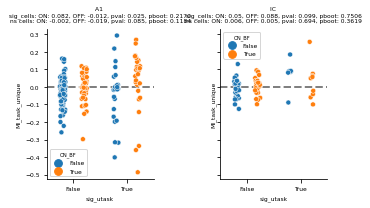

In [4]:
import os
import helpers as helper
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import nems.db as nd
from nems import get_setting
import nems.plots.api as nplt
from nems_lbhb.analysis.statistics import get_bootstrapped_sample, get_direct_prob

dump_path = get_setting('NEMS_RESULTS_DIR')

save_path = os.path.join(os.path.expanduser('~'),'docs/current/pupil_behavior/eps')
save_fig = False

r0_threshold = 0.5
octave_cutoff = 0.5
yaxis_task = 'MI_task_unique'
AFL = True
if AFL:
    dump_results = 'd_pup_afl_sdexp.csv'
    #dump_results = 'd_pup_afl_sdexp_ap1.csv'
    model_string = 'st.pup.afl'
    p0_model = 'st.pup0.afl'
    b0_model = 'st.pup.afl0'
    shuf_model = 'st.pup0.afl0'
else:
    dump_results = 'd_pup_fil_sdexp.csv'
    model_string = 'st.pup.fil'
    p0_model = 'st.pup0.fil'
    b0_model = 'st.pup.fil0'
    shuf_model = 'st.pup0.fil0'

# NOTE: Decided not to show ON/OFF MI for pupil because effects are tiny. Instead, just show
# that pxf performance = pxf0 so there is no interaction between task and pupil effects

A1 = helper.preprocess_sdexp_dump(dump_results,
                                  batch=307,
                                  full_model=model_string,
                                  p0=p0_model,
                                  b0=b0_model,
                                  shuf_model=shuf_model,
                                  r0_threshold=r0_threshold,
                                  octave_cutoff=octave_cutoff,
                                  path=dump_path)
A1 = A1[A1.sig_psth]

IC = helper.preprocess_sdexp_dump(dump_results,
                                  batch=309,
                                  full_model=model_string,
                                  p0=p0_model,
                                  b0=b0_model,
                                  shuf_model=shuf_model,
                                  r0_threshold=r0_threshold,
                                  octave_cutoff=octave_cutoff,
                                  path=dump_path)
IC = IC[IC.sig_psth]


f, ax = plt.subplots(1, 2, figsize=(5,3), sharey='row')

sns.stripplot(x='sig_utask', y=yaxis_task, data=A1, hue='ON_BF', dodge=True, edgecolor='white', linewidth=0.5,
                        marker='o', size=5, ax=ax[0])
ax[0].axhline(0, linestyle='--', lw=2, color='grey')

pval = round(ss.ranksums(A1[A1.ON_BF & A1.sig_utask][yaxis_task], A1[~A1.ON_BF & A1.sig_utask][yaxis_task]).pvalue, 3)
off_med = round(A1[~A1.ON_BF & A1.sig_utask][yaxis_task].median(), 3)
on_med = round(A1[A1.ON_BF & A1.sig_utask][yaxis_task].median(), 3)
# get bootstrapped pval
A1['site'] = [c[:7] for c in A1.index]
sig_a1_on = get_bootstrapped_sample({s: A1[A1.ON_BF & A1.sig_utask & (A1.site==s)][yaxis_task] for s in A1.site.unique()}, nboot=1000)
sig_a1_off = get_bootstrapped_sample({s: A1[~A1.ON_BF & A1.sig_utask & (A1.site==s)][yaxis_task] for s in A1.site.unique()}, nboot=1000)
pboot, jm = get_direct_prob(sig_a1_on, sig_a1_off)

pval_ns = round(ss.ranksums(A1[A1.ON_BF & ~A1.sig_utask][yaxis_task], A1[~A1.ON_BF & ~A1.sig_utask][yaxis_task]).pvalue, 3)
off_med_ns = round(A1[~A1.ON_BF & ~A1.sig_utask][yaxis_task].median(), 3)
on_med_ns = round(A1[A1.ON_BF & ~A1.sig_utask][yaxis_task].median(), 3)
ns_a1_on = get_bootstrapped_sample({s: A1[A1.ON_BF & ~A1.sig_utask & (A1.site==s)][yaxis_task] for s in A1.site.unique()}, nboot=1000)
ns_a1_off = get_bootstrapped_sample({s: A1[~A1.ON_BF & ~A1.sig_utask & (A1.site==s)][yaxis_task] for s in A1.site.unique()}, nboot=1000)
pboot_ns, jm = get_direct_prob(ns_a1_on, ns_a1_off)

ax[0].set_title('A1 \n sig_cells: ON: {0}, OFF: {1}, pval: {2}, pboot: {6:.4f} \n'
                    'ns cells: ON: {3}, OFF: {4}, pval: {5}, pboot: {7:.4f}'.format(on_med, off_med, pval, on_med_ns, off_med_ns, pval_ns, pboot, pboot_ns))
nplt.ax_remove_box(ax[0])


sns.stripplot(x='sig_utask', y=yaxis_task, data=IC, hue='ON_BF', dodge=True, edgecolor='white', linewidth=0.5,
                        marker='o', size=5, ax=ax[1])
ax[1].axhline(0, linestyle='--', lw=2, color='grey')

pval = round(ss.ranksums(IC[IC.ON_BF & IC.sig_utask][yaxis_task], IC[~IC.ON_BF & IC.sig_utask][yaxis_task]).pvalue, 3)
off_med = round(IC[~IC.ON_BF & IC.sig_utask][yaxis_task].median(), 3)
on_med = round(IC[IC.ON_BF & IC.sig_utask][yaxis_task].median(), 3)
IC['site'] = [c[:7] for c in IC.index]
sig_ic_on = get_bootstrapped_sample({s: IC[IC.ON_BF & IC.sig_utask & (IC.site==s)][yaxis_task] for s in IC.site.unique()}, nboot=1000)
sig_ic_off = get_bootstrapped_sample({s: IC[~IC.ON_BF & IC.sig_utask & (IC.site==s)][yaxis_task] for s in IC.site.unique()}, nboot=1000)
pboot, jm = get_direct_prob(sig_ic_on, sig_ic_off)

pval_ns = round(ss.ranksums(IC[IC.ON_BF & ~IC.sig_utask][yaxis_task], IC[~IC.ON_BF & ~IC.sig_utask][yaxis_task]).pvalue, 3)
off_med_ns = round(IC[~IC.ON_BF & ~IC.sig_utask][yaxis_task].median(), 3)
on_med_ns = round(IC[IC.ON_BF & ~IC.sig_utask][yaxis_task].median(), 3)
ns_ic_on = get_bootstrapped_sample({s: IC[IC.ON_BF & ~IC.sig_utask & (IC.site==s)][yaxis_task] for s in IC.site.unique()}, nboot=1000)
ns_ic_off = get_bootstrapped_sample({s: IC[~IC.ON_BF & ~IC.sig_utask & (IC.site==s)][yaxis_task] for s in IC.site.unique()}, nboot=1000)
pboot_ns, jm = get_direct_prob(ns_ic_on, ns_ic_off)

ax[1].set_title('IC \n sig_cells: ON: {0}, OFF: {1}, pval: {2}, pboot: {6:.4f} \n'
                    'ns cells: ON: {3}, OFF: {4}, pval: {5}, pboot: {7:.4f}'.format(on_med, off_med, pval, on_med_ns, off_med_ns, pval_ns, pboot, pboot_ns))
nplt.ax_remove_box(ax[1])
f.tight_layout()

if 0:
    # plot individual model results for gain, MI, dc pupil and task
    f, ax = helper.stripplot_df(A1, hue='ON_BF', group_files=group_files)
    f.canvas.set_window_title('A1')
    f, ax = helper.stripplot_df(IC, hue='ON_BF', group_files=group_files)
    f.canvas.set_window_title('IC')

plt.show()

if save_fig:
    f.savefig(os.path.join(save_path,'figS3_on_off_BF.pdf'))


In [12]:
    rec = recording.load_recording('/auto/data/nems_db/recordings/307/AMT018a_0c7b41bb773433ca12df509de0048c3300f22e15.tgz')
    pupil = rec['pupil']
    active = pupil.epoch_to_signal('ACTIVE_EXPERIMENT')
    active.chans = ['active']

    p = pupil.as_continuous()[0, :]
    b = active.as_continuous()[0, :]
    g = np.isfinite(p) & np.isfinite(b)
    cc_pup_beh = np.corrcoef(p[g], b[g])[0, 1]

    pshift = np.int(pupil.fs * 0.75)
    #pupil = pupil._modified_copy(np.roll(pupil._data, (0, pshift)))
    d = pupil._data
    pupil = pupil._modified_copy(np.roll(d / np.nanmax(d), (0, pshift)))
    #pupil = pupil._modified_copy(d / np.nanmax(d))
    #pupil = pupil._modified_copy(np.roll(d, (0, pshift)))

    trials = pupil.get_epoch_indices('TRIAL')
    targets = pupil.get_epoch_indices('TARGET')
    pt_blocks = pupil.get_epoch_indices('PURETONE_BEHAVIOR').tolist()
    easy_blocks = pupil.get_epoch_indices('EASY_BEHAVIOR').tolist()
    hard_blocks = pupil.get_epoch_indices('HARD_BEHAVIOR').tolist()
    passive_blocks = pupil.get_epoch_indices('PASSIVE_EXPERIMENT').tolist()
    behavior_blocks = pupil.get_epoch_indices('ACTIVE_EXPERIMENT')


In [16]:
easy_blocks

[]